In [ ]:
! pip install tqdm

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

Setting seeds to gget the same results with all runs

In [ ]:
import torch
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(39)

# Data Loader


Creating a data loader function as seen in the lab examples to load the CIFAR10 dataset to crate the train and test data. Normalization values have been taken from https://www.kaggle.com/code/fanbyprinciple/cifar10-explanation-with-pytorch in order to save time and not iterate over the entire entire dataset.



In [ ]:
def load_data_cifar10(batch_size, resize=None):
    """Download the CIFAR10 dataset and then load it into memory."""
    trans = [
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
    ]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    cifar_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)
    cifar_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans, download=True)

    return (
        torch.utils.data.DataLoader(cifar_train, batch_size, shuffle=True, num_workers=2, pin_memory=True),
        torch.utils.data.DataLoader(cifar_test, batch_size, shuffle=False, num_workers=2, pin_memory=True)
    )

In [ ]:
batch_size = 128 # Defines the batch size
train_iter, test_iter = load_data_cifar10(batch_size) # `train_iter` and `test_iter` are `DataLoader` objects.

100%|██████████| 170M/170M [00:03<00:00, 47.6MB/s]


In [ ]:
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # 256 images per batch. Each image is represented by a 3 x 32 x 32 tensor (number of channels x height x width)
print(y.size()) # 256 targets. Each target is a number between 0 and 9. The classification problem has 10 clases.

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [ ]:
print(train_iter.dataset.data.shape)
print(test_iter.dataset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


# Basic Neural network architecture

## building the intermediate blocks

For a given input image tensor x:

It passes x through L convolutional layers (each with its own hyperparameters).

It computes the mean per channel of x as vector m (size = number of channels).

It passes m through a fully connected (FC) layer to get L scalar weights [a1, a2, ..., aL].

The output is the weighted sum of the outputs of each CNN layer:

$$ x' = \sum_{i=1}^L a_i.C_i(x)$$

In [ ]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_params_list):
        """
        in_channels: number of channels in the input image
        out_channels: number of output channels for each conv layer
        conv_params_list: list of dicts, one per conv layer, each specifying 'kernel_size', 'stride', etc.
        """
        super().__init__()
        self.L = len(conv_params_list)

        # create L convolutional layers
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, **params),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            ) for params in conv_params_list
        ])


        # fully connected layer to compute weights a1, ..., aL
        self.fc = nn.Linear(in_channels, self.L)

    def forward(self, x):
        batch_size = x.shape[0]

        # apply each convolution layer to the input, shape will be [B, C_out, H, W]
        conv_outputs = [conv(x) for conv in self.convs]

        # checking shapes match
        out_shapes = [out.shape for out in conv_outputs]
        assert all(s == out_shapes[0] for s in out_shapes), "conv outputs must have same shape"

        # computing channel-wise mean of input image x to use as input for the fuly connected layer, shape will be [B, C_in]
        m = x.mean(dim=[2, 3])

        # weights a = [a1, ..., aL], shape: [B, L]
        a = self.fc(m)
         # normalize weights to sum to 1
        a = F.softmax(a, dim=1)

        # weighted sum of conv outputs
        weighted_sum = sum(a[:, i].view(batch_size, 1, 1, 1) * conv_outputs[i]
                           for i in range(self.L))

        return weighted_sum

## Defining the output block

Takes image x (shape [B, C, H, W])

Computes per-channel mean → vector m (shape [B, C])

Feeds m into a sequence of fully connecected layers

Final output: 10-dimensional logits (one per class)

In [ ]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, hidden_units=64, num_classes=10):
        super().__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(in_channels, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, num_classes)
        )

    def forward(self, x):
        # x: [B, C, H, W]
        m = x.mean(dim=[2, 3])  # shape: [B, C]
        return self.fc_layers(m)  # shape: [B, 10]

## Defining the model class

In [ ]:
class CIFAR10CustomNet(nn.Module):
    def __init__(self,
                 in_channels=3,
                 num_blocks=3,
                 conv_params_per_block=None,
                 out_channels_per_block=16,
                 output_hidden_units=64):
        """
        conv_params_per_block: list of lists of conv param dicts, one list per block
        """
        super().__init__()
        self.blocks = nn.ModuleList()

        current_channels = in_channels
        for block_idx in range(num_blocks):
            conv_params = conv_params_per_block[block_idx]
            block = IntermediateBlock(current_channels, out_channels_per_block, conv_params)
            self.blocks.append(block)
            # output shape becomes input to next block
            current_channels = out_channels_per_block

        self.output_block = OutputBlock(in_channels=current_channels,
                                        hidden_units=output_hidden_units)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        out = self.output_block(x)
        return out  # logits shape: [B, 10]


accuracy function

In [ ]:
def accuracy(y_hat, y):
    """Compute number of correct predictions"""
    preds = y_hat.argmax(dim=1)
    return (preds == y).sum().item()

##Training function

In [ ]:
from tqdm import tqdm
def train_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    batch_losses = []

    progress_bar = tqdm(train_loader, desc="Training Batches", leave=False)


    for X, y in progress_bar :
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        total_loss += loss.item() * X.shape[0]
        total_correct += accuracy(y_hat, y)
        total_samples += X.shape[0]

    avg_loss = total_loss / total_samples
    train_acc = total_correct / total_samples
    return avg_loss, train_acc, batch_losses

## Evaluation function

In [ ]:
def evaluate(model, test_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            total_loss += loss.item() * X.shape[0]
            total_correct += accuracy(y_hat, y)
            total_samples += X.shape[0]

    avg_loss = total_loss / total_samples
    test_acc = total_correct / total_samples
    return avg_loss, test_acc


Plots

In [ ]:
import matplotlib.pyplot as plt

def plot_batch_losses(batch_losses):
    plt.figure(figsize=(10, 4))
    plt.plot(batch_losses, label='Training Loss (per batch)')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Batch')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_epoch_accuracies(train_acc, test_acc):
    epochs = list(range(1, len(train_acc) + 1))
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, test_acc, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()


## Training loop

In [ ]:

def train_model(model, train_loader, test_loader, device,
                num_epochs=100, lr=0.001):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': [],
        'batch_losses': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc, batch_losses = train_epoch(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['batch_losses'].extend(batch_losses)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

    # Plotting after training completes
    plot_batch_losses(history['batch_losses'])
    plot_epoch_accuracies(history['train_acc'], history['test_acc'])

    # Print best test accuracy
    best_test_acc = max(history['test_acc'])
    print(f"\n Best Testing Accuracy: {best_test_acc:.4f}")

    return history


## Running standard architercture

Epoch 1: Train Loss=1.6203, Train Acc=0.3910, Test Loss=1.7224, Test Acc=0.4088


Epoch 2: Train Loss=1.2135, Train Acc=0.5542, Test Loss=1.4598, Test Acc=0.4810


Epoch 3: Train Loss=1.0389, Train Acc=0.6240, Test Loss=1.1364, Test Acc=0.5836


Epoch 4: Train Loss=0.9291, Train Acc=0.6669, Test Loss=1.1037, Test Acc=0.6053


Epoch 5: Train Loss=0.8532, Train Acc=0.6948, Test Loss=1.0350, Test Acc=0.6363


Epoch 6: Train Loss=0.7964, Train Acc=0.7148, Test Loss=1.2773, Test Acc=0.5868


Epoch 7: Train Loss=0.7442, Train Acc=0.7332, Test Loss=1.3521, Test Acc=0.5509


Epoch 8: Train Loss=0.7043, Train Acc=0.7490, Test Loss=0.8992, Test Acc=0.6882


Epoch 9: Train Loss=0.6680, Train Acc=0.7620, Test Loss=0.9353, Test Acc=0.6722


Epoch 10: Train Loss=0.6373, Train Acc=0.7740, Test Loss=1.0110, Test Acc=0.6747


Epoch 11: Train Loss=0.6091, Train Acc=0.7832, Test Loss=0.9043, Test Acc=0.6979


Epoch 12: Train Loss=0.5862, Train Acc=0.7932, Test Loss=0.7276, Test Acc=0.7492


Epoch 13: Train Loss=0.5600, Train Acc=0.8015, Test Loss=1.1413, Test Acc=0.6450


Epoch 14: Train Loss=0.5358, Train Acc=0.8095, Test Loss=1.1510, Test Acc=0.6415


Epoch 15: Train Loss=0.5191, Train Acc=0.8152, Test Loss=0.9219, Test Acc=0.6962


Epoch 16: Train Loss=0.4976, Train Acc=0.8243, Test Loss=0.9756, Test Acc=0.6834


Epoch 17: Train Loss=0.4805, Train Acc=0.8293, Test Loss=0.8363, Test Acc=0.7210


Epoch 18: Train Loss=0.4663, Train Acc=0.8354, Test Loss=1.0254, Test Acc=0.6786


Epoch 19: Train Loss=0.4518, Train Acc=0.8398, Test Loss=0.8607, Test Acc=0.7178


Epoch 20: Train Loss=0.4327, Train Acc=0.8486, Test Loss=0.9570, Test Acc=0.7102


Epoch 21: Train Loss=0.4218, Train Acc=0.8523, Test Loss=1.1376, Test Acc=0.6808


Epoch 22: Train Loss=0.4048, Train Acc=0.8569, Test Loss=1.0274, Test Acc=0.6917


Epoch 23: Train Loss=0.3985, Train Acc=0.8585, Test Loss=0.8496, Test Acc=0.7277


Epoch 24: Train Loss=0.3774, Train Acc=0.8646, Test Loss=1.3976, Test Acc=0.6406


Epoch 25: Train Loss=0.3701, Train Acc=0.8692, Test Loss=0.7622, Test Acc=0.7639


Epoch 26: Train Loss=0.3549, Train Acc=0.8746, Test Loss=1.7836, Test Acc=0.5758


Epoch 27: Train Loss=0.3412, Train Acc=0.8791, Test Loss=1.8257, Test Acc=0.5918


Epoch 28: Train Loss=0.3336, Train Acc=0.8808, Test Loss=1.0256, Test Acc=0.7114


Epoch 29: Train Loss=0.3239, Train Acc=0.8856, Test Loss=0.8443, Test Acc=0.7505


Epoch 30: Train Loss=0.3103, Train Acc=0.8899, Test Loss=1.0003, Test Acc=0.7148


Epoch 31: Train Loss=0.3027, Train Acc=0.8918, Test Loss=1.0321, Test Acc=0.7165


Epoch 32: Train Loss=0.2938, Train Acc=0.8951, Test Loss=1.5345, Test Acc=0.6365


Epoch 33: Train Loss=0.2833, Train Acc=0.8999, Test Loss=0.9872, Test Acc=0.7225


Epoch 34: Train Loss=0.2718, Train Acc=0.9023, Test Loss=1.7175, Test Acc=0.6214


Epoch 35: Train Loss=0.2648, Train Acc=0.9054, Test Loss=1.6397, Test Acc=0.6511


Epoch 36: Train Loss=0.2553, Train Acc=0.9086, Test Loss=1.1814, Test Acc=0.7104


Epoch 37: Train Loss=0.2477, Train Acc=0.9132, Test Loss=1.1971, Test Acc=0.7032


Epoch 38: Train Loss=0.2402, Train Acc=0.9144, Test Loss=1.3234, Test Acc=0.6810


Epoch 39: Train Loss=0.2312, Train Acc=0.9171, Test Loss=0.7349, Test Acc=0.7899


Epoch 40: Train Loss=0.2254, Train Acc=0.9197, Test Loss=0.7602, Test Acc=0.7916


Epoch 41: Train Loss=0.2227, Train Acc=0.9204, Test Loss=0.8844, Test Acc=0.7611


Epoch 42: Train Loss=0.2136, Train Acc=0.9227, Test Loss=1.1627, Test Acc=0.7039


Epoch 43: Train Loss=0.1971, Train Acc=0.9287, Test Loss=1.5718, Test Acc=0.6608


Epoch 44: Train Loss=0.1982, Train Acc=0.9289, Test Loss=1.1875, Test Acc=0.7141


Epoch 45: Train Loss=0.1880, Train Acc=0.9335, Test Loss=0.9812, Test Acc=0.7463


Epoch 46: Train Loss=0.1827, Train Acc=0.9345, Test Loss=1.6271, Test Acc=0.6658


Epoch 47: Train Loss=0.1771, Train Acc=0.9353, Test Loss=1.0481, Test Acc=0.7441


Epoch 48: Train Loss=0.1696, Train Acc=0.9390, Test Loss=1.5786, Test Acc=0.6669


Epoch 49: Train Loss=0.1660, Train Acc=0.9407, Test Loss=1.2050, Test Acc=0.7197


Epoch 50: Train Loss=0.1537, Train Acc=0.9448, Test Loss=1.9944, Test Acc=0.6389


Epoch 51: Train Loss=0.1570, Train Acc=0.9425, Test Loss=1.2414, Test Acc=0.7302


Epoch 52: Train Loss=0.1529, Train Acc=0.9445, Test Loss=0.9015, Test Acc=0.7816


Epoch 53: Train Loss=0.1466, Train Acc=0.9472, Test Loss=1.3881, Test Acc=0.7126


Epoch 54: Train Loss=0.1447, Train Acc=0.9470, Test Loss=1.3433, Test Acc=0.7326


Epoch 55: Train Loss=0.1307, Train Acc=0.9522, Test Loss=1.4231, Test Acc=0.7169


Epoch 56: Train Loss=0.1350, Train Acc=0.9509, Test Loss=1.9798, Test Acc=0.6609


Epoch 57: Train Loss=0.1279, Train Acc=0.9542, Test Loss=1.2944, Test Acc=0.7236


Epoch 58: Train Loss=0.1272, Train Acc=0.9537, Test Loss=1.7291, Test Acc=0.6942


Epoch 59: Train Loss=0.1181, Train Acc=0.9576, Test Loss=1.0528, Test Acc=0.7672


Epoch 60: Train Loss=0.1183, Train Acc=0.9572, Test Loss=1.6501, Test Acc=0.7051


Epoch 61: Train Loss=0.1182, Train Acc=0.9570, Test Loss=2.1322, Test Acc=0.6512


Epoch 62: Train Loss=0.1127, Train Acc=0.9588, Test Loss=1.3559, Test Acc=0.7365


Epoch 63: Train Loss=0.1055, Train Acc=0.9620, Test Loss=1.6301, Test Acc=0.7197


Epoch 64: Train Loss=0.0959, Train Acc=0.9658, Test Loss=1.4276, Test Acc=0.7284


Epoch 65: Train Loss=0.1098, Train Acc=0.9594, Test Loss=1.5952, Test Acc=0.7121


Epoch 66: Train Loss=0.0996, Train Acc=0.9639, Test Loss=1.4532, Test Acc=0.7340


Epoch 67: Train Loss=0.1017, Train Acc=0.9635, Test Loss=1.3414, Test Acc=0.7434


Epoch 68: Train Loss=0.0901, Train Acc=0.9677, Test Loss=1.1440, Test Acc=0.7675


Epoch 69: Train Loss=0.0962, Train Acc=0.9651, Test Loss=1.6332, Test Acc=0.7178


Epoch 70: Train Loss=0.0920, Train Acc=0.9672, Test Loss=1.4299, Test Acc=0.7447


Epoch 71: Train Loss=0.0950, Train Acc=0.9647, Test Loss=1.1833, Test Acc=0.7716


Epoch 72: Train Loss=0.0827, Train Acc=0.9705, Test Loss=1.6448, Test Acc=0.7130


Epoch 73: Train Loss=0.0840, Train Acc=0.9705, Test Loss=1.6783, Test Acc=0.7291


Epoch 74: Train Loss=0.0819, Train Acc=0.9713, Test Loss=1.9916, Test Acc=0.6767


Epoch 75: Train Loss=0.0804, Train Acc=0.9710, Test Loss=2.1296, Test Acc=0.6801


Epoch 76: Train Loss=0.0863, Train Acc=0.9681, Test Loss=1.0489, Test Acc=0.7943


Epoch 77: Train Loss=0.0751, Train Acc=0.9740, Test Loss=1.2190, Test Acc=0.7769


Epoch 78: Train Loss=0.0749, Train Acc=0.9722, Test Loss=2.7564, Test Acc=0.6295


Epoch 79: Train Loss=0.0717, Train Acc=0.9740, Test Loss=1.7161, Test Acc=0.7283


Epoch 80: Train Loss=0.0733, Train Acc=0.9738, Test Loss=1.7049, Test Acc=0.7176


Epoch 81: Train Loss=0.0702, Train Acc=0.9745, Test Loss=1.6610, Test Acc=0.7309


Epoch 82: Train Loss=0.0686, Train Acc=0.9753, Test Loss=1.4290, Test Acc=0.7568


Epoch 83: Train Loss=0.0712, Train Acc=0.9734, Test Loss=4.3561, Test Acc=0.5236


Epoch 84: Train Loss=0.0680, Train Acc=0.9754, Test Loss=1.6991, Test Acc=0.7256


Epoch 85: Train Loss=0.0630, Train Acc=0.9777, Test Loss=2.0562, Test Acc=0.6885


Epoch 86: Train Loss=0.0653, Train Acc=0.9759, Test Loss=1.6176, Test Acc=0.7366


Epoch 87: Train Loss=0.0737, Train Acc=0.9737, Test Loss=1.8041, Test Acc=0.7078


Epoch 88: Train Loss=0.0682, Train Acc=0.9750, Test Loss=1.4155, Test Acc=0.7551


Epoch 89: Train Loss=0.0566, Train Acc=0.9802, Test Loss=2.0321, Test Acc=0.6936


Epoch 90: Train Loss=0.0606, Train Acc=0.9787, Test Loss=1.8732, Test Acc=0.7202


Epoch 91: Train Loss=0.0609, Train Acc=0.9787, Test Loss=2.2177, Test Acc=0.6978


Epoch 92: Train Loss=0.0625, Train Acc=0.9776, Test Loss=1.5537, Test Acc=0.7482


Epoch 93: Train Loss=0.0577, Train Acc=0.9796, Test Loss=1.8268, Test Acc=0.7314


Epoch 94: Train Loss=0.0619, Train Acc=0.9775, Test Loss=2.5110, Test Acc=0.6779


Epoch 95: Train Loss=0.0590, Train Acc=0.9786, Test Loss=1.4832, Test Acc=0.7527


Epoch 96: Train Loss=0.0515, Train Acc=0.9814, Test Loss=3.1510, Test Acc=0.6469


Epoch 97: Train Loss=0.0581, Train Acc=0.9790, Test Loss=1.6751, Test Acc=0.7528


Epoch 98: Train Loss=0.0540, Train Acc=0.9810, Test Loss=1.7476, Test Acc=0.7466


Epoch 99: Train Loss=0.0511, Train Acc=0.9815, Test Loss=1.6956, Test Acc=0.7450


Epoch 100: Train Loss=0.0524, Train Acc=0.9819, Test Loss=1.7914, Test Acc=0.7395


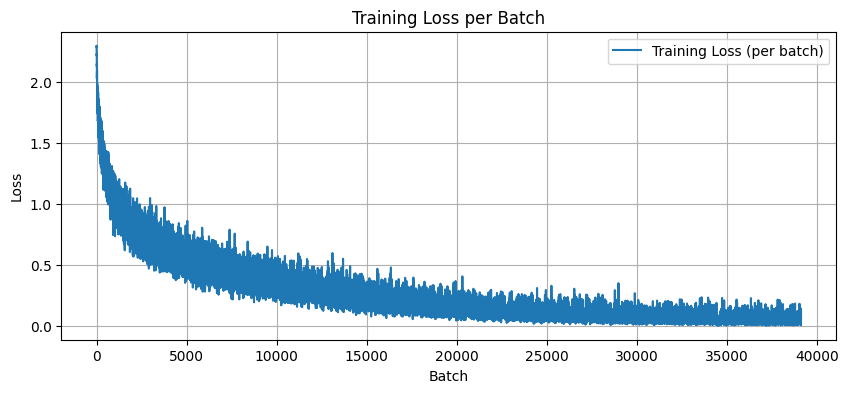

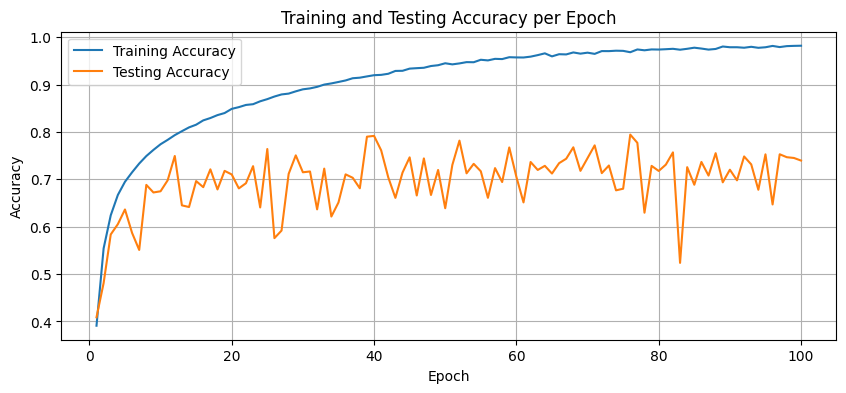


 Best Testing Accuracy: 0.7943


In [ ]:
K = 5  # Number of intermediate blocks
L = 3  # Number of conv layers per block
out_channels_per_block = 32
output_hidden_units = 128
learning_rate = 0.001
num_epochs = 100
batch_size = 128

# 3 conv layers per block with different kernel sizes
conv_params_template = [
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 5, 'padding': 2},
    {'kernel_size': 1, 'padding': 0}
]

# Same template for all K blocks
conv_params_per_block = [conv_params_template for _ in range(K)]

#initialize model
model = CIFAR10CustomNet(
    in_channels=3,
    num_blocks=K,
    conv_params_per_block=conv_params_per_block,
    out_channels_per_block=out_channels_per_block,
    output_hidden_units=output_hidden_units
)

#run training
train_iter, test_iter = load_data_cifar10(batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')

history = train_model(
    model, train_iter, test_iter, device,
    num_epochs=num_epochs,
    lr=learning_rate
)

# Improvements

Step by step strategy to improve\
Step 1:

* The model appeared to be overfitting, so adding dropout layers might be a good practice.
* Weight decay that was mentioned as a regularization method in week 6 will encourage smaller weights as it adds the weights to the loss function and encourages smaller (positive or negative) weights.

Step 2:
* trying K = 6, L = 4, out_channels=64 might enrich the representation
* using inspiration from VGG by using consistent and small 3*3 filters
* trying different drpout rates or fc hidden sizes

## Improvements round 1

In [ ]:
"""
# modifying ouput block to have dropout
class OutputBlock(nn.Module):
    def __init__(self, in_channels, hidden_units=128, num_classes=10, dropout_p=0.3):
        super().__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(in_channels, hidden_units),
            nn.ReLU(),
            #dropout added
            nn.Dropout(p=dropout_p),
            nn.Linear(hidden_units, num_classes)
        )

    def forward(self, x):
        m = x.mean(dim=[2, 3])  # Average over H and W
        return self.fc_layers(m)

# update optimizer with weight decay
def train_model(model, train_loader, test_loader, device,
                num_epochs=100, lr=0.001):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)


    history = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': [],
        'batch_losses': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc, batch_losses = train_epoch(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['batch_losses'].extend(batch_losses)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

    # Plotting after training completes
    plot_batch_losses(history['batch_losses'])
    plot_epoch_accuracies(history['train_acc'], history['test_acc'])

    # Print best test accuracy
    best_test_acc = max(history['test_acc'])
    print(f"\n Best Testing Accuracy: {best_test_acc:.4f}")

    return history
"""

Epoch 1: Train Loss=1.6422, Train Acc=0.3723, Test Loss=1.4759, Test Acc=0.4450


Epoch 2: Train Loss=1.2429, Train Acc=0.5441, Test Loss=1.2541, Test Acc=0.5485


Epoch 3: Train Loss=1.0552, Train Acc=0.6191, Test Loss=1.1066, Test Acc=0.6024


Epoch 4: Train Loss=0.9494, Train Acc=0.6595, Test Loss=1.0089, Test Acc=0.6244


Epoch 5: Train Loss=0.8821, Train Acc=0.6844, Test Loss=1.1226, Test Acc=0.5931


Epoch 6: Train Loss=0.8235, Train Acc=0.7079, Test Loss=1.3835, Test Acc=0.5470


Epoch 7: Train Loss=0.7775, Train Acc=0.7234, Test Loss=0.9159, Test Acc=0.6769


Epoch 8: Train Loss=0.7383, Train Acc=0.7394, Test Loss=1.2266, Test Acc=0.5844


Epoch 9: Train Loss=0.7039, Train Acc=0.7515, Test Loss=1.0378, Test Acc=0.6455


Epoch 10: Train Loss=0.6761, Train Acc=0.7615, Test Loss=0.9899, Test Acc=0.6593


Epoch 11: Train Loss=0.6466, Train Acc=0.7725, Test Loss=1.3715, Test Acc=0.5763


Epoch 12: Train Loss=0.6248, Train Acc=0.7820, Test Loss=1.1147, Test Acc=0.6440


Epoch 13: Train Loss=0.6029, Train Acc=0.7899, Test Loss=0.8702, Test Acc=0.6908


Epoch 14: Train Loss=0.5785, Train Acc=0.7987, Test Loss=0.8844, Test Acc=0.7057


Epoch 15: Train Loss=0.5557, Train Acc=0.8060, Test Loss=1.0253, Test Acc=0.6616


Epoch 16: Train Loss=0.5410, Train Acc=0.8127, Test Loss=0.9784, Test Acc=0.6873


Epoch 17: Train Loss=0.5229, Train Acc=0.8194, Test Loss=0.7849, Test Acc=0.7367


Epoch 18: Train Loss=0.5083, Train Acc=0.8228, Test Loss=0.7405, Test Acc=0.7458


Epoch 19: Train Loss=0.4902, Train Acc=0.8305, Test Loss=1.0125, Test Acc=0.6757


Epoch 20: Train Loss=0.4694, Train Acc=0.8379, Test Loss=1.1362, Test Acc=0.6435


Epoch 21: Train Loss=0.4569, Train Acc=0.8408, Test Loss=1.1405, Test Acc=0.6530


Epoch 22: Train Loss=0.4412, Train Acc=0.8486, Test Loss=1.7127, Test Acc=0.5632


Epoch 23: Train Loss=0.4294, Train Acc=0.8506, Test Loss=0.8851, Test Acc=0.7107


Epoch 24: Train Loss=0.4145, Train Acc=0.8559, Test Loss=0.9529, Test Acc=0.6997


Epoch 25: Train Loss=0.4036, Train Acc=0.8597, Test Loss=0.7384, Test Acc=0.7622


Epoch 26: Train Loss=0.3942, Train Acc=0.8627, Test Loss=0.7865, Test Acc=0.7520


Epoch 27: Train Loss=0.3787, Train Acc=0.8683, Test Loss=0.9984, Test Acc=0.7045


Epoch 28: Train Loss=0.3699, Train Acc=0.8724, Test Loss=1.2262, Test Acc=0.6516


Epoch 29: Train Loss=0.3531, Train Acc=0.8763, Test Loss=1.4255, Test Acc=0.6285


Epoch 30: Train Loss=0.3490, Train Acc=0.8783, Test Loss=1.8201, Test Acc=0.5572


Epoch 31: Train Loss=0.3413, Train Acc=0.8809, Test Loss=1.3624, Test Acc=0.6428


Epoch 32: Train Loss=0.3297, Train Acc=0.8853, Test Loss=0.9693, Test Acc=0.7197


Epoch 33: Train Loss=0.3213, Train Acc=0.8884, Test Loss=0.9372, Test Acc=0.7447


Epoch 34: Train Loss=0.3147, Train Acc=0.8900, Test Loss=0.7309, Test Acc=0.7765


Epoch 35: Train Loss=0.3017, Train Acc=0.8948, Test Loss=0.6940, Test Acc=0.7885


Epoch 36: Train Loss=0.2943, Train Acc=0.8969, Test Loss=1.5526, Test Acc=0.6303


Epoch 37: Train Loss=0.2832, Train Acc=0.9018, Test Loss=0.8725, Test Acc=0.7468


Epoch 38: Train Loss=0.2742, Train Acc=0.9046, Test Loss=1.2379, Test Acc=0.7010


Epoch 39: Train Loss=0.2711, Train Acc=0.9040, Test Loss=1.2531, Test Acc=0.6764


Epoch 40: Train Loss=0.2561, Train Acc=0.9106, Test Loss=0.8843, Test Acc=0.7610


Epoch 41: Train Loss=0.2572, Train Acc=0.9092, Test Loss=2.0330, Test Acc=0.5836


Epoch 42: Train Loss=0.2471, Train Acc=0.9125, Test Loss=0.8653, Test Acc=0.7641


Epoch 43: Train Loss=0.2457, Train Acc=0.9141, Test Loss=1.2355, Test Acc=0.6866


Epoch 44: Train Loss=0.2352, Train Acc=0.9177, Test Loss=0.8337, Test Acc=0.7709


Epoch 45: Train Loss=0.2287, Train Acc=0.9195, Test Loss=1.1548, Test Acc=0.7217


Epoch 46: Train Loss=0.2220, Train Acc=0.9226, Test Loss=1.0882, Test Acc=0.7269


Epoch 47: Train Loss=0.2192, Train Acc=0.9208, Test Loss=1.0737, Test Acc=0.7311


Epoch 48: Train Loss=0.2120, Train Acc=0.9251, Test Loss=1.0882, Test Acc=0.7390


Epoch 49: Train Loss=0.2069, Train Acc=0.9266, Test Loss=1.0076, Test Acc=0.7556


Epoch 50: Train Loss=0.1971, Train Acc=0.9298, Test Loss=0.9149, Test Acc=0.7675


Epoch 51: Train Loss=0.1946, Train Acc=0.9306, Test Loss=1.7767, Test Acc=0.6441


Epoch 52: Train Loss=0.1917, Train Acc=0.9324, Test Loss=1.1218, Test Acc=0.7238


Epoch 53: Train Loss=0.1830, Train Acc=0.9354, Test Loss=1.4779, Test Acc=0.7004


Epoch 54: Train Loss=0.1767, Train Acc=0.9375, Test Loss=1.4992, Test Acc=0.6902


Epoch 55: Train Loss=0.1733, Train Acc=0.9382, Test Loss=1.1473, Test Acc=0.7225


Epoch 56: Train Loss=0.1704, Train Acc=0.9395, Test Loss=1.5055, Test Acc=0.6936


Epoch 57: Train Loss=0.1673, Train Acc=0.9392, Test Loss=2.0489, Test Acc=0.6229


Epoch 58: Train Loss=0.1559, Train Acc=0.9451, Test Loss=1.3370, Test Acc=0.7184


Epoch 59: Train Loss=0.1588, Train Acc=0.9438, Test Loss=1.5951, Test Acc=0.6866


Epoch 60: Train Loss=0.1555, Train Acc=0.9430, Test Loss=1.1610, Test Acc=0.7463


Epoch 61: Train Loss=0.1518, Train Acc=0.9459, Test Loss=1.4112, Test Acc=0.6970


Epoch 62: Train Loss=0.1463, Train Acc=0.9478, Test Loss=3.3042, Test Acc=0.5468


Epoch 63: Train Loss=0.1397, Train Acc=0.9499, Test Loss=1.2569, Test Acc=0.7181


Epoch 64: Train Loss=0.1379, Train Acc=0.9509, Test Loss=0.9451, Test Acc=0.7874


Epoch 65: Train Loss=0.1285, Train Acc=0.9552, Test Loss=0.9347, Test Acc=0.7816


Epoch 66: Train Loss=0.1333, Train Acc=0.9519, Test Loss=1.6658, Test Acc=0.6831


Epoch 67: Train Loss=0.1306, Train Acc=0.9532, Test Loss=1.0224, Test Acc=0.7731


Epoch 68: Train Loss=0.1237, Train Acc=0.9553, Test Loss=1.4378, Test Acc=0.7146


Epoch 69: Train Loss=0.1247, Train Acc=0.9546, Test Loss=2.2242, Test Acc=0.6497


Epoch 70: Train Loss=0.1200, Train Acc=0.9575, Test Loss=1.1238, Test Acc=0.7586


Epoch 71: Train Loss=0.1164, Train Acc=0.9590, Test Loss=1.6427, Test Acc=0.7162


Epoch 72: Train Loss=0.1089, Train Acc=0.9613, Test Loss=1.7920, Test Acc=0.6940


Epoch 73: Train Loss=0.1159, Train Acc=0.9582, Test Loss=1.2311, Test Acc=0.7513


Epoch 74: Train Loss=0.1076, Train Acc=0.9609, Test Loss=1.5217, Test Acc=0.7152


Epoch 75: Train Loss=0.1073, Train Acc=0.9620, Test Loss=1.7229, Test Acc=0.7186


Epoch 76: Train Loss=0.1088, Train Acc=0.9610, Test Loss=1.2389, Test Acc=0.7419


Epoch 77: Train Loss=0.1026, Train Acc=0.9633, Test Loss=1.7624, Test Acc=0.6944


Epoch 78: Train Loss=0.1017, Train Acc=0.9642, Test Loss=1.2570, Test Acc=0.7579


Epoch 79: Train Loss=0.1016, Train Acc=0.9639, Test Loss=1.6967, Test Acc=0.7088


Epoch 80: Train Loss=0.0968, Train Acc=0.9655, Test Loss=1.4560, Test Acc=0.7280


Epoch 81: Train Loss=0.1001, Train Acc=0.9651, Test Loss=1.1254, Test Acc=0.7741


Epoch 82: Train Loss=0.0965, Train Acc=0.9653, Test Loss=1.7709, Test Acc=0.7049


Epoch 83: Train Loss=0.0901, Train Acc=0.9685, Test Loss=1.5650, Test Acc=0.7399


Epoch 84: Train Loss=0.0894, Train Acc=0.9680, Test Loss=1.8341, Test Acc=0.7141


Epoch 85: Train Loss=0.0915, Train Acc=0.9680, Test Loss=1.6163, Test Acc=0.7086


Epoch 86: Train Loss=0.0850, Train Acc=0.9703, Test Loss=1.3671, Test Acc=0.7536


Epoch 87: Train Loss=0.0823, Train Acc=0.9707, Test Loss=1.2101, Test Acc=0.7756


Epoch 88: Train Loss=0.0820, Train Acc=0.9705, Test Loss=2.6841, Test Acc=0.6223


Epoch 89: Train Loss=0.0836, Train Acc=0.9702, Test Loss=2.6529, Test Acc=0.6195


Epoch 90: Train Loss=0.0826, Train Acc=0.9698, Test Loss=1.9857, Test Acc=0.6805


Epoch 91: Train Loss=0.0802, Train Acc=0.9721, Test Loss=2.2609, Test Acc=0.6939


Epoch 92: Train Loss=0.0800, Train Acc=0.9711, Test Loss=1.8902, Test Acc=0.7109


Epoch 93: Train Loss=0.0772, Train Acc=0.9727, Test Loss=1.2933, Test Acc=0.7626


Epoch 94: Train Loss=0.0801, Train Acc=0.9713, Test Loss=1.5803, Test Acc=0.7354


Epoch 95: Train Loss=0.0743, Train Acc=0.9733, Test Loss=2.1794, Test Acc=0.6903


Epoch 96: Train Loss=0.0725, Train Acc=0.9745, Test Loss=1.8667, Test Acc=0.6903


Epoch 97: Train Loss=0.0746, Train Acc=0.9739, Test Loss=1.3753, Test Acc=0.7616


Epoch 98: Train Loss=0.0739, Train Acc=0.9749, Test Loss=1.6643, Test Acc=0.7386


Epoch 99: Train Loss=0.0697, Train Acc=0.9752, Test Loss=1.7108, Test Acc=0.7179


Epoch 100: Train Loss=0.0687, Train Acc=0.9753, Test Loss=1.4162, Test Acc=0.7425


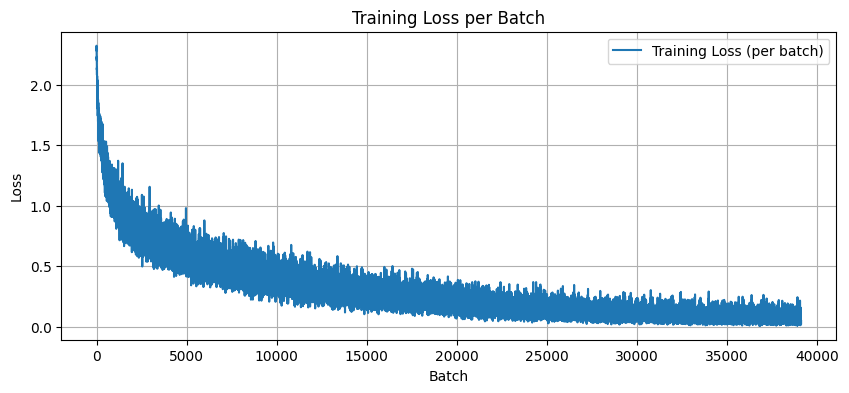

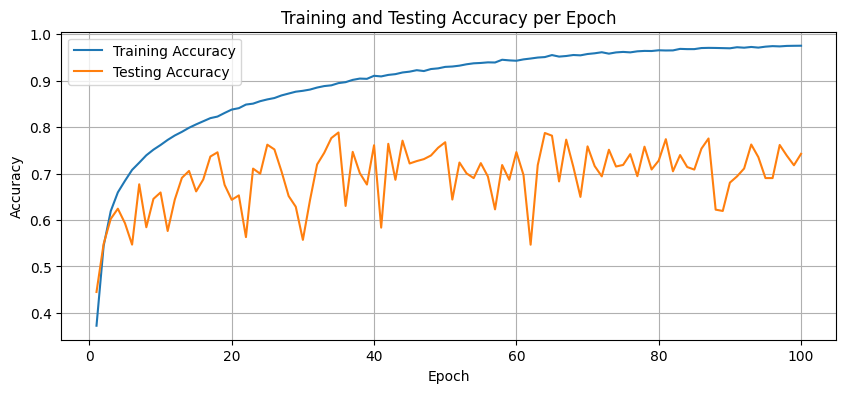


 Best Testing Accuracy: 0.7885


In [ ]:
# taining
K = 5  # Number of intermediate blocks
L = 3  # Number of conv layers per block
out_channels_per_block = 32
output_hidden_units = 128
learning_rate = 0.001
num_epochs = 100
batch_size = 128

# 3 conv layers per block with different kernel sizes
conv_params_template = [
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 5, 'padding': 2},
    {'kernel_size': 1, 'padding': 0}
]

# Same template for all K blocks
conv_params_per_block = [conv_params_template for _ in range(K)]

#initialize model
model = CIFAR10CustomNet(
    in_channels=3,
    num_blocks=K,
    conv_params_per_block=conv_params_per_block,
    out_channels_per_block=out_channels_per_block,
    output_hidden_units=output_hidden_units
)

#run training
train_iter, test_iter = load_data_cifar10(batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')

history = train_model(
    model, train_iter, test_iter, device,
    num_epochs=num_epochs,
    lr=learning_rate
)

## Improvements 2

deeper network with more conv layers and vgg style cons

Epoch 1: Train Loss=1.5152, Train Acc=0.4310, Test Loss=1.6332, Test Acc=0.4053


Epoch 2: Train Loss=1.1146, Train Acc=0.5920, Test Loss=1.3611, Test Acc=0.5126


Epoch 3: Train Loss=0.9431, Train Acc=0.6593, Test Loss=1.9768, Test Acc=0.4079


Epoch 4: Train Loss=0.8318, Train Acc=0.7019, Test Loss=1.0709, Test Acc=0.6306


Epoch 5: Train Loss=0.7534, Train Acc=0.7314, Test Loss=1.2692, Test Acc=0.5790


Epoch 6: Train Loss=0.6778, Train Acc=0.7586, Test Loss=0.8675, Test Acc=0.7016


Epoch 7: Train Loss=0.6177, Train Acc=0.7823, Test Loss=1.0843, Test Acc=0.6492


Epoch 8: Train Loss=0.5732, Train Acc=0.7971, Test Loss=0.7253, Test Acc=0.7531


Epoch 9: Train Loss=0.5241, Train Acc=0.8150, Test Loss=0.9713, Test Acc=0.6928


Epoch 10: Train Loss=0.4791, Train Acc=0.8314, Test Loss=1.3551, Test Acc=0.5944


Epoch 11: Train Loss=0.4523, Train Acc=0.8429, Test Loss=0.7404, Test Acc=0.7512


Epoch 12: Train Loss=0.4076, Train Acc=0.8575, Test Loss=0.9592, Test Acc=0.7120


Epoch 13: Train Loss=0.3812, Train Acc=0.8671, Test Loss=0.7776, Test Acc=0.7442


Epoch 14: Train Loss=0.3552, Train Acc=0.8751, Test Loss=0.9506, Test Acc=0.7127


Epoch 15: Train Loss=0.3305, Train Acc=0.8841, Test Loss=1.0356, Test Acc=0.7046


Epoch 16: Train Loss=0.3047, Train Acc=0.8926, Test Loss=0.7078, Test Acc=0.7834


Epoch 17: Train Loss=0.2855, Train Acc=0.9008, Test Loss=0.6608, Test Acc=0.7917


Epoch 18: Train Loss=0.2642, Train Acc=0.9072, Test Loss=1.2921, Test Acc=0.6565


Epoch 19: Train Loss=0.2388, Train Acc=0.9165, Test Loss=0.8921, Test Acc=0.7566


Epoch 20: Train Loss=0.2309, Train Acc=0.9186, Test Loss=0.8975, Test Acc=0.7406


Epoch 21: Train Loss=0.2090, Train Acc=0.9254, Test Loss=0.8767, Test Acc=0.7508


Epoch 22: Train Loss=0.1885, Train Acc=0.9332, Test Loss=1.5558, Test Acc=0.6395


Epoch 23: Train Loss=0.1725, Train Acc=0.9388, Test Loss=1.7977, Test Acc=0.6665


Epoch 24: Train Loss=0.1594, Train Acc=0.9427, Test Loss=1.1669, Test Acc=0.7314


Epoch 25: Train Loss=0.1522, Train Acc=0.9452, Test Loss=1.0069, Test Acc=0.7594


Epoch 26: Train Loss=0.1350, Train Acc=0.9521, Test Loss=1.8968, Test Acc=0.6459


Epoch 27: Train Loss=0.1333, Train Acc=0.9528, Test Loss=0.9850, Test Acc=0.7706


Epoch 28: Train Loss=0.1195, Train Acc=0.9564, Test Loss=1.0737, Test Acc=0.7515


Epoch 29: Train Loss=0.1148, Train Acc=0.9594, Test Loss=0.9375, Test Acc=0.7867


Epoch 30: Train Loss=0.1003, Train Acc=0.9638, Test Loss=0.8291, Test Acc=0.8042


Epoch 31: Train Loss=0.0985, Train Acc=0.9652, Test Loss=1.2513, Test Acc=0.7458


Epoch 32: Train Loss=0.0909, Train Acc=0.9681, Test Loss=0.8928, Test Acc=0.7965


Epoch 33: Train Loss=0.0887, Train Acc=0.9679, Test Loss=1.5493, Test Acc=0.7117


Epoch 34: Train Loss=0.0853, Train Acc=0.9711, Test Loss=0.8145, Test Acc=0.8207


Epoch 35: Train Loss=0.0702, Train Acc=0.9759, Test Loss=1.1107, Test Acc=0.7814


Epoch 36: Train Loss=0.0764, Train Acc=0.9731, Test Loss=1.5258, Test Acc=0.7297


Epoch 37: Train Loss=0.0678, Train Acc=0.9766, Test Loss=1.2831, Test Acc=0.7774


Epoch 38: Train Loss=0.0664, Train Acc=0.9768, Test Loss=1.0364, Test Acc=0.7913


Epoch 39: Train Loss=0.0693, Train Acc=0.9742, Test Loss=1.6923, Test Acc=0.7145


Epoch 40: Train Loss=0.0595, Train Acc=0.9790, Test Loss=1.8013, Test Acc=0.6992


Epoch 41: Train Loss=0.0661, Train Acc=0.9769, Test Loss=1.5654, Test Acc=0.7286


Epoch 42: Train Loss=0.0561, Train Acc=0.9803, Test Loss=1.5319, Test Acc=0.7635


Epoch 43: Train Loss=0.0657, Train Acc=0.9766, Test Loss=1.0008, Test Acc=0.8063


Epoch 44: Train Loss=0.0505, Train Acc=0.9827, Test Loss=1.4121, Test Acc=0.7689


Epoch 45: Train Loss=0.0507, Train Acc=0.9821, Test Loss=1.3897, Test Acc=0.7631


Epoch 46: Train Loss=0.0496, Train Acc=0.9826, Test Loss=1.0591, Test Acc=0.8048


Epoch 47: Train Loss=0.0546, Train Acc=0.9808, Test Loss=1.1646, Test Acc=0.7931


Epoch 48: Train Loss=0.0430, Train Acc=0.9849, Test Loss=1.4016, Test Acc=0.7633


Epoch 49: Train Loss=0.0505, Train Acc=0.9828, Test Loss=1.8925, Test Acc=0.7352


Epoch 50: Train Loss=0.0537, Train Acc=0.9812, Test Loss=1.0089, Test Acc=0.8077


Epoch 51: Train Loss=0.0324, Train Acc=0.9898, Test Loss=1.3304, Test Acc=0.8042


Epoch 52: Train Loss=0.0459, Train Acc=0.9836, Test Loss=1.6646, Test Acc=0.7551


Epoch 53: Train Loss=0.0432, Train Acc=0.9847, Test Loss=1.5762, Test Acc=0.7716


Epoch 54: Train Loss=0.0411, Train Acc=0.9855, Test Loss=2.0354, Test Acc=0.6971


Epoch 55: Train Loss=0.0467, Train Acc=0.9832, Test Loss=1.3640, Test Acc=0.7821


Epoch 56: Train Loss=0.0413, Train Acc=0.9854, Test Loss=1.2134, Test Acc=0.7912


Epoch 57: Train Loss=0.0426, Train Acc=0.9844, Test Loss=1.1027, Test Acc=0.8041


Epoch 58: Train Loss=0.0308, Train Acc=0.9897, Test Loss=0.8230, Test Acc=0.8421


Epoch 59: Train Loss=0.0337, Train Acc=0.9883, Test Loss=1.5545, Test Acc=0.7811


Epoch 60: Train Loss=0.0335, Train Acc=0.9889, Test Loss=1.3690, Test Acc=0.7775


Epoch 61: Train Loss=0.0411, Train Acc=0.9859, Test Loss=0.9198, Test Acc=0.8261


Epoch 62: Train Loss=0.0380, Train Acc=0.9873, Test Loss=1.2432, Test Acc=0.8032


Epoch 63: Train Loss=0.0377, Train Acc=0.9871, Test Loss=1.0484, Test Acc=0.8184


Epoch 64: Train Loss=0.0339, Train Acc=0.9878, Test Loss=3.1068, Test Acc=0.6411


Epoch 65: Train Loss=0.0310, Train Acc=0.9897, Test Loss=1.0038, Test Acc=0.8254


Epoch 66: Train Loss=0.0309, Train Acc=0.9897, Test Loss=1.3716, Test Acc=0.7821


Epoch 67: Train Loss=0.0345, Train Acc=0.9878, Test Loss=1.1907, Test Acc=0.8027


Epoch 68: Train Loss=0.0321, Train Acc=0.9886, Test Loss=1.6805, Test Acc=0.7466


Epoch 69: Train Loss=0.0305, Train Acc=0.9898, Test Loss=1.1654, Test Acc=0.8075


Epoch 70: Train Loss=0.0364, Train Acc=0.9877, Test Loss=1.0934, Test Acc=0.8279


Epoch 71: Train Loss=0.0229, Train Acc=0.9921, Test Loss=1.2684, Test Acc=0.8102


Epoch 72: Train Loss=0.0337, Train Acc=0.9885, Test Loss=1.0979, Test Acc=0.8181


Epoch 73: Train Loss=0.0215, Train Acc=0.9926, Test Loss=1.2263, Test Acc=0.8118


Epoch 74: Train Loss=0.0327, Train Acc=0.9886, Test Loss=1.3956, Test Acc=0.7838


Epoch 75: Train Loss=0.0326, Train Acc=0.9884, Test Loss=1.1204, Test Acc=0.8089


Epoch 76: Train Loss=0.0263, Train Acc=0.9906, Test Loss=1.2217, Test Acc=0.8051


Epoch 77: Train Loss=0.0301, Train Acc=0.9898, Test Loss=0.9921, Test Acc=0.8250


Epoch 78: Train Loss=0.0247, Train Acc=0.9915, Test Loss=0.8891, Test Acc=0.8454


Epoch 79: Train Loss=0.0223, Train Acc=0.9920, Test Loss=1.0402, Test Acc=0.8285


Epoch 80: Train Loss=0.0384, Train Acc=0.9861, Test Loss=1.1857, Test Acc=0.8091


Epoch 81: Train Loss=0.0190, Train Acc=0.9933, Test Loss=0.9025, Test Acc=0.8513


Epoch 82: Train Loss=0.0185, Train Acc=0.9939, Test Loss=1.6354, Test Acc=0.7637


Epoch 83: Train Loss=0.0378, Train Acc=0.9874, Test Loss=1.1779, Test Acc=0.8116


Epoch 84: Train Loss=0.0201, Train Acc=0.9931, Test Loss=1.8434, Test Acc=0.7584


Epoch 85: Train Loss=0.0188, Train Acc=0.9935, Test Loss=0.9224, Test Acc=0.8356


Epoch 86: Train Loss=0.0333, Train Acc=0.9884, Test Loss=1.0899, Test Acc=0.8249


Epoch 87: Train Loss=0.0176, Train Acc=0.9940, Test Loss=1.0281, Test Acc=0.8207


Epoch 88: Train Loss=0.0206, Train Acc=0.9923, Test Loss=0.9940, Test Acc=0.8361


Epoch 89: Train Loss=0.0218, Train Acc=0.9924, Test Loss=0.9268, Test Acc=0.8402


Epoch 90: Train Loss=0.0186, Train Acc=0.9940, Test Loss=1.1296, Test Acc=0.8289


Epoch 91: Train Loss=0.0357, Train Acc=0.9871, Test Loss=1.6285, Test Acc=0.7703


Epoch 92: Train Loss=0.0200, Train Acc=0.9932, Test Loss=1.2323, Test Acc=0.8243


Epoch 93: Train Loss=0.0155, Train Acc=0.9949, Test Loss=1.4821, Test Acc=0.7911


Epoch 94: Train Loss=0.0303, Train Acc=0.9892, Test Loss=1.3044, Test Acc=0.8051


Epoch 95: Train Loss=0.0160, Train Acc=0.9946, Test Loss=1.1881, Test Acc=0.8205


Epoch 96: Train Loss=0.0235, Train Acc=0.9919, Test Loss=1.2014, Test Acc=0.8192


Epoch 97: Train Loss=0.0178, Train Acc=0.9942, Test Loss=1.1590, Test Acc=0.8228


Epoch 98: Train Loss=0.0247, Train Acc=0.9914, Test Loss=1.0336, Test Acc=0.8245


Epoch 99: Train Loss=0.0150, Train Acc=0.9948, Test Loss=1.8954, Test Acc=0.7561


Epoch 100: Train Loss=0.0241, Train Acc=0.9917, Test Loss=1.2586, Test Acc=0.8191


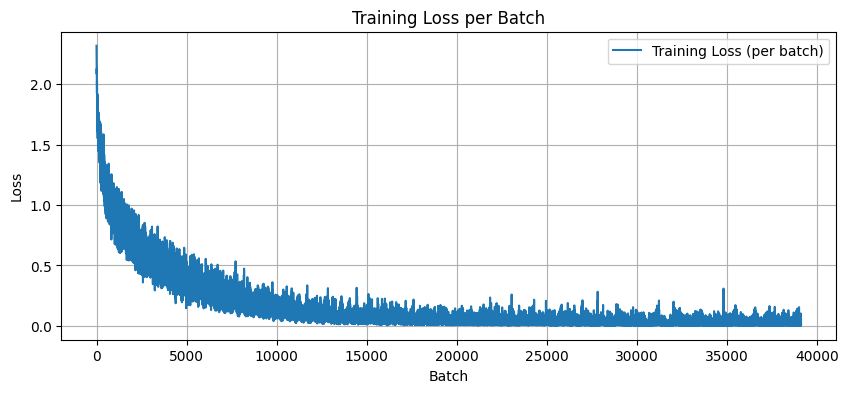

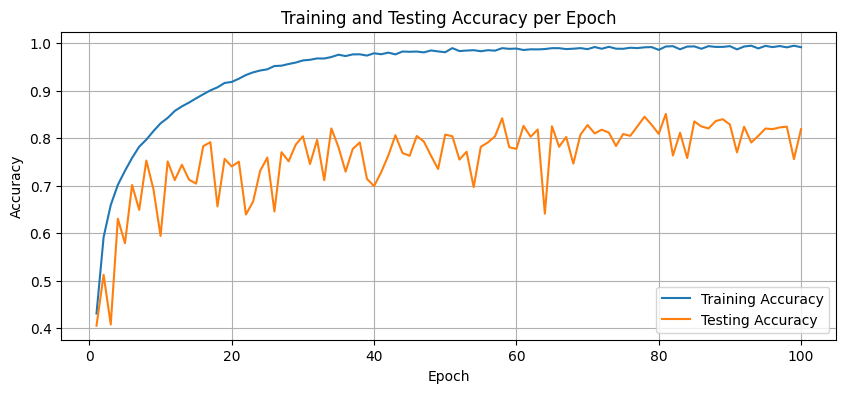


 Best Testing Accuracy: 0.8513


In [ ]:
K = 6
L = 4
out_channels_per_block = 64
output_hidden_units = 128
batch_size = 128
num_epochs = 100
learning_rate = 0.001

# 4 conv layers of 3x3 padding=1 (VGG style)
conv_params_template = [
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1}
]
conv_params_per_block = [conv_params_template for _ in range(K)]

model = CIFAR10CustomNet(
    in_channels=3,
    num_blocks=K,
    conv_params_per_block=conv_params_per_block,
    out_channels_per_block=out_channels_per_block,
    output_hidden_units=output_hidden_units
)
train_iter, test_iter = load_data_cifar10(batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_imp2 = train_model(
    model, train_iter, test_iter, device,
    num_epochs=num_epochs,
    lr=learning_rate
)

Improvement 3
adding LR scheduler and batch norm

In [ ]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_params_list):
        super().__init__()
        self.L = len(conv_params_list)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, **params),
                #added batch norm
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
            for params in conv_params_list
        ])

        self.fc = nn.Linear(in_channels, self.L)

    def forward(self, x):
        batch_size = x.shape[0]
        conv_outputs = [conv(x) for conv in self.convs]

        # Verify shapes are identical
        out_shapes = [out.shape for out in conv_outputs]
        assert all(s == out_shapes[0] for s in out_shapes), "Conv outputs must match shape"

        m = x.mean(dim=[2, 3])  # Per-channel mean
        a = self.fc(m)
        a = F.softmax(a, dim=1)

        weighted_sum = sum(
            a[:, i].view(batch_size, 1, 1, 1) * conv_outputs[i]
            for i in range(self.L)
        )
        return weighted_sum


In [ ]:
def train_model(model, train_loader, test_loader, device,
                num_epochs=100, lr=0.001):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    #LR scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)


    history = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': [],
        'batch_losses': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc, batch_losses = train_epoch(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
        #giving the test accuracy as LR step
        scheduler.step(test_acc)


        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['batch_losses'].extend(batch_losses)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

    # Plotting after training completes
    plot_batch_losses(history['batch_losses'])
    plot_epoch_accuracies(history['train_acc'], history['test_acc'])

    # Print best test accuracy
    best_test_acc = max(history['test_acc'])
    print(f"\n Best Testing Accuracy: {best_test_acc:.4f}")

    return history

Epoch 1: Train Loss=1.5132, Train Acc=0.4315, Test Loss=1.5085, Test Acc=0.4396


Epoch 2: Train Loss=1.1359, Train Acc=0.5848, Test Loss=1.5234, Test Acc=0.4605


Epoch 3: Train Loss=0.9621, Train Acc=0.6516, Test Loss=1.9552, Test Acc=0.4524


Epoch 4: Train Loss=0.8644, Train Acc=0.6904, Test Loss=1.1477, Test Acc=0.5977


Epoch 5: Train Loss=0.7843, Train Acc=0.7197, Test Loss=1.6281, Test Acc=0.5112


Epoch 6: Train Loss=0.7267, Train Acc=0.7418, Test Loss=1.0818, Test Acc=0.6133


Epoch 7: Train Loss=0.6699, Train Acc=0.7633, Test Loss=1.1393, Test Acc=0.6226


Epoch 8: Train Loss=0.6282, Train Acc=0.7791, Test Loss=0.8537, Test Acc=0.7079


Epoch 9: Train Loss=0.5862, Train Acc=0.7962, Test Loss=1.5038, Test Acc=0.5573


Epoch 10: Train Loss=0.5472, Train Acc=0.8095, Test Loss=1.1545, Test Acc=0.6345


Epoch 11: Train Loss=0.5208, Train Acc=0.8173, Test Loss=1.4171, Test Acc=0.5684


Epoch 12: Train Loss=0.4852, Train Acc=0.8319, Test Loss=1.2513, Test Acc=0.6365


Epoch 13: Train Loss=0.4593, Train Acc=0.8395, Test Loss=1.0559, Test Acc=0.6725


Epoch 14: Train Loss=0.4366, Train Acc=0.8488, Test Loss=0.6056, Test Acc=0.7883


Epoch 15: Train Loss=0.4230, Train Acc=0.8533, Test Loss=0.9977, Test Acc=0.6850


Epoch 16: Train Loss=0.4037, Train Acc=0.8620, Test Loss=0.8702, Test Acc=0.7279


Epoch 17: Train Loss=0.3838, Train Acc=0.8673, Test Loss=1.2141, Test Acc=0.6354


Epoch 18: Train Loss=0.3662, Train Acc=0.8736, Test Loss=0.8744, Test Acc=0.7318


Epoch 19: Train Loss=0.3523, Train Acc=0.8779, Test Loss=0.7528, Test Acc=0.7510


Epoch 20: Train Loss=0.3380, Train Acc=0.8833, Test Loss=0.9153, Test Acc=0.7292


Epoch 21: Train Loss=0.2274, Train Acc=0.9233, Test Loss=0.9607, Test Acc=0.7328


Epoch 22: Train Loss=0.1988, Train Acc=0.9338, Test Loss=1.1199, Test Acc=0.6962


Epoch 23: Train Loss=0.1928, Train Acc=0.9351, Test Loss=0.6280, Test Acc=0.8018


Epoch 24: Train Loss=0.1775, Train Acc=0.9409, Test Loss=0.8567, Test Acc=0.7506


Epoch 25: Train Loss=0.1638, Train Acc=0.9467, Test Loss=0.8653, Test Acc=0.7448


Epoch 26: Train Loss=0.1578, Train Acc=0.9471, Test Loss=1.7527, Test Acc=0.6458


Epoch 27: Train Loss=0.1474, Train Acc=0.9506, Test Loss=0.9711, Test Acc=0.7463


Epoch 28: Train Loss=0.1415, Train Acc=0.9520, Test Loss=0.9958, Test Acc=0.7261


Epoch 29: Train Loss=0.1288, Train Acc=0.9566, Test Loss=0.9971, Test Acc=0.7332


Epoch 30: Train Loss=0.0633, Train Acc=0.9841, Test Loss=0.4842, Test Acc=0.8574


Epoch 31: Train Loss=0.0420, Train Acc=0.9924, Test Loss=0.5422, Test Acc=0.8444


Epoch 32: Train Loss=0.0370, Train Acc=0.9935, Test Loss=0.6846, Test Acc=0.8344


Epoch 33: Train Loss=0.0399, Train Acc=0.9920, Test Loss=0.6972, Test Acc=0.8209


Epoch 34: Train Loss=0.0438, Train Acc=0.9898, Test Loss=0.8609, Test Acc=0.7821


Epoch 35: Train Loss=0.0474, Train Acc=0.9881, Test Loss=0.5978, Test Acc=0.8292


Epoch 36: Train Loss=0.0414, Train Acc=0.9909, Test Loss=0.8512, Test Acc=0.7850


Epoch 37: Train Loss=0.0192, Train Acc=0.9980, Test Loss=0.5111, Test Acc=0.8609


Epoch 38: Train Loss=0.0136, Train Acc=0.9995, Test Loss=0.5018, Test Acc=0.8629


Epoch 39: Train Loss=0.0125, Train Acc=0.9994, Test Loss=0.5229, Test Acc=0.8576


Epoch 40: Train Loss=0.0118, Train Acc=0.9995, Test Loss=0.5363, Test Acc=0.8547


Epoch 41: Train Loss=0.0134, Train Acc=0.9993, Test Loss=0.5503, Test Acc=0.8464


Epoch 42: Train Loss=0.0151, Train Acc=0.9988, Test Loss=0.5909, Test Acc=0.8384


Epoch 43: Train Loss=0.0179, Train Acc=0.9984, Test Loss=0.5538, Test Acc=0.8529


Epoch 44: Train Loss=0.0164, Train Acc=0.9987, Test Loss=0.5896, Test Acc=0.8463


Epoch 45: Train Loss=0.0094, Train Acc=0.9998, Test Loss=0.4716, Test Acc=0.8691


Epoch 46: Train Loss=0.0078, Train Acc=0.9999, Test Loss=0.4987, Test Acc=0.8623


Epoch 47: Train Loss=0.0074, Train Acc=1.0000, Test Loss=0.4975, Test Acc=0.8609


Epoch 48: Train Loss=0.0078, Train Acc=0.9999, Test Loss=0.4865, Test Acc=0.8667


Epoch 49: Train Loss=0.0080, Train Acc=0.9998, Test Loss=0.4967, Test Acc=0.8616


Epoch 50: Train Loss=0.0086, Train Acc=0.9999, Test Loss=0.5275, Test Acc=0.8606


Epoch 51: Train Loss=0.0082, Train Acc=0.9999, Test Loss=0.7298, Test Acc=0.8164


Epoch 52: Train Loss=0.0070, Train Acc=0.9999, Test Loss=0.4654, Test Acc=0.8675


Epoch 53: Train Loss=0.0065, Train Acc=1.0000, Test Loss=0.4742, Test Acc=0.8711


Epoch 54: Train Loss=0.0064, Train Acc=1.0000, Test Loss=0.4686, Test Acc=0.8684


Epoch 55: Train Loss=0.0067, Train Acc=1.0000, Test Loss=0.4687, Test Acc=0.8685


Epoch 56: Train Loss=0.0067, Train Acc=1.0000, Test Loss=0.4693, Test Acc=0.8669


Epoch 57: Train Loss=0.0068, Train Acc=1.0000, Test Loss=0.4660, Test Acc=0.8689


Epoch 58: Train Loss=0.0069, Train Acc=1.0000, Test Loss=0.4769, Test Acc=0.8653


Epoch 59: Train Loss=0.0068, Train Acc=1.0000, Test Loss=0.4683, Test Acc=0.8694


Epoch 60: Train Loss=0.0062, Train Acc=1.0000, Test Loss=0.4578, Test Acc=0.8695


Epoch 61: Train Loss=0.0059, Train Acc=1.0000, Test Loss=0.4557, Test Acc=0.8683


Epoch 62: Train Loss=0.0057, Train Acc=1.0000, Test Loss=0.4597, Test Acc=0.8703


Epoch 63: Train Loss=0.0060, Train Acc=1.0000, Test Loss=0.4651, Test Acc=0.8691


Epoch 64: Train Loss=0.0062, Train Acc=1.0000, Test Loss=0.4654, Test Acc=0.8677


Epoch 65: Train Loss=0.0059, Train Acc=1.0000, Test Loss=0.4527, Test Acc=0.8692


Epoch 66: Train Loss=0.0056, Train Acc=1.0000, Test Loss=0.4546, Test Acc=0.8695


Epoch 67: Train Loss=0.0057, Train Acc=1.0000, Test Loss=0.4577, Test Acc=0.8701


Epoch 68: Train Loss=0.0059, Train Acc=1.0000, Test Loss=0.4555, Test Acc=0.8696


Epoch 69: Train Loss=0.0057, Train Acc=1.0000, Test Loss=0.4522, Test Acc=0.8703


Epoch 70: Train Loss=0.0058, Train Acc=1.0000, Test Loss=0.4529, Test Acc=0.8698


Epoch 71: Train Loss=0.0058, Train Acc=1.0000, Test Loss=0.4550, Test Acc=0.8691


Epoch 72: Train Loss=0.0056, Train Acc=1.0000, Test Loss=0.4518, Test Acc=0.8684


Epoch 73: Train Loss=0.0056, Train Acc=1.0000, Test Loss=0.4542, Test Acc=0.8707


Epoch 74: Train Loss=0.0055, Train Acc=1.0000, Test Loss=0.4523, Test Acc=0.8702


Epoch 75: Train Loss=0.0056, Train Acc=1.0000, Test Loss=0.4541, Test Acc=0.8698


Epoch 76: Train Loss=0.0057, Train Acc=1.0000, Test Loss=0.4511, Test Acc=0.8707


Epoch 77: Train Loss=0.0056, Train Acc=1.0000, Test Loss=0.4509, Test Acc=0.8699


Epoch 78: Train Loss=0.0054, Train Acc=1.0000, Test Loss=0.4546, Test Acc=0.8697


Epoch 79: Train Loss=0.0055, Train Acc=1.0000, Test Loss=0.4519, Test Acc=0.8707


Epoch 80: Train Loss=0.0055, Train Acc=1.0000, Test Loss=0.4506, Test Acc=0.8705


Epoch 81: Train Loss=0.0055, Train Acc=1.0000, Test Loss=0.4528, Test Acc=0.8705


Epoch 82: Train Loss=0.0055, Train Acc=1.0000, Test Loss=0.4517, Test Acc=0.8692


Epoch 83: Train Loss=0.0055, Train Acc=1.0000, Test Loss=0.4516, Test Acc=0.8702


Epoch 84: Train Loss=0.0054, Train Acc=1.0000, Test Loss=0.4512, Test Acc=0.8695


Epoch 85: Train Loss=0.0055, Train Acc=1.0000, Test Loss=0.4533, Test Acc=0.8686


Epoch 86: Train Loss=0.0053, Train Acc=1.0000, Test Loss=0.4499, Test Acc=0.8702


Epoch 87: Train Loss=0.0054, Train Acc=1.0000, Test Loss=0.4509, Test Acc=0.8704


Epoch 88: Train Loss=0.0056, Train Acc=1.0000, Test Loss=0.4591, Test Acc=0.8692


Epoch 89: Train Loss=0.0055, Train Acc=1.0000, Test Loss=0.4507, Test Acc=0.8705


Epoch 90: Train Loss=0.0056, Train Acc=1.0000, Test Loss=0.4498, Test Acc=0.8702


Epoch 91: Train Loss=0.0054, Train Acc=1.0000, Test Loss=0.4518, Test Acc=0.8701


Epoch 92: Train Loss=0.0054, Train Acc=1.0000, Test Loss=0.4507, Test Acc=0.8700


Epoch 93: Train Loss=0.0053, Train Acc=1.0000, Test Loss=0.4515, Test Acc=0.8695


Epoch 94: Train Loss=0.0056, Train Acc=1.0000, Test Loss=0.4526, Test Acc=0.8689


Epoch 95: Train Loss=0.0055, Train Acc=1.0000, Test Loss=0.4522, Test Acc=0.8693


Epoch 96: Train Loss=0.0054, Train Acc=1.0000, Test Loss=0.4510, Test Acc=0.8702


Epoch 97: Train Loss=0.0053, Train Acc=1.0000, Test Loss=0.4503, Test Acc=0.8713


Epoch 98: Train Loss=0.0053, Train Acc=1.0000, Test Loss=0.4516, Test Acc=0.8697


Epoch 99: Train Loss=0.0054, Train Acc=1.0000, Test Loss=0.4511, Test Acc=0.8706


Epoch 100: Train Loss=0.0056, Train Acc=1.0000, Test Loss=0.4516, Test Acc=0.8696


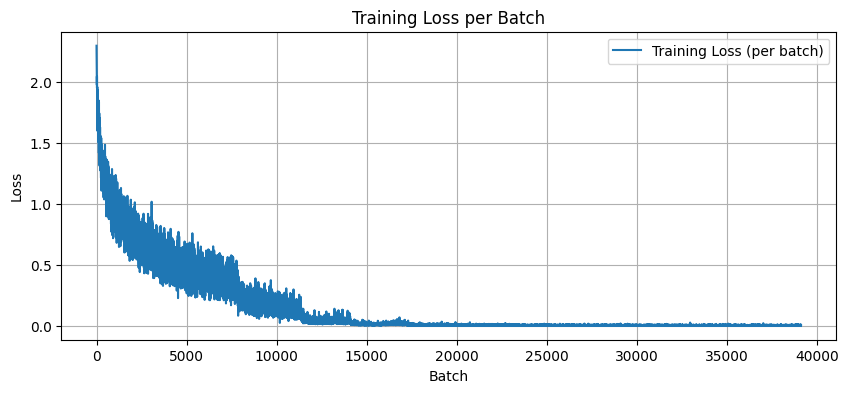

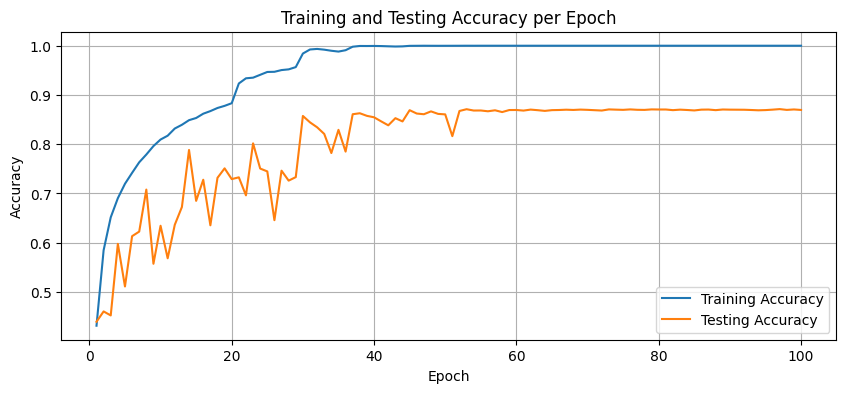


 Best Testing Accuracy: 0.8713


In [ ]:
K = 6
L = 4
out_channels_per_block = 64
output_hidden_units = 128
batch_size = 128
num_epochs = 100
learning_rate = 0.001

conv_params_template = [
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1}
]
conv_params_per_block = [conv_params_template for _ in range(K)]
model = CIFAR10CustomNet(
    in_channels=3,
    num_blocks=K,
    conv_params_per_block=conv_params_per_block,
    out_channels_per_block=out_channels_per_block,
    output_hidden_units=output_hidden_units
)
train_iter, test_iter = load_data_cifar10(batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')
history_imp3 = train_model(
    model, train_iter, test_iter, device,
    num_epochs=num_epochs,
    lr=learning_rate
)

Improvement 4
data augmentation

In [ ]:
def load_data_cifar10(batch_size, resize=None):
    """Load CIFAR-10 with augmentation for training data."""
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )

    train_transforms = [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        normalize
    ]

    test_transforms = [
        transforms.ToTensor(),
        normalize
    ]

    cifar_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=transforms.Compose(train_transforms), download=True)
    cifar_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=transforms.Compose(test_transforms), download=True)

    return (
        torch.utils.data.DataLoader(cifar_train, batch_size, shuffle=True, num_workers=2, pin_memory=True),
        torch.utils.data.DataLoader(cifar_test, batch_size, shuffle=False, num_workers=2, pin_memory=True)
    )


Epoch 1: Train Loss=1.6055, Train Acc=0.3888, Test Loss=1.4947, Test Acc=0.4376


Epoch 2: Train Loss=1.2324, Train Acc=0.5477, Test Loss=1.4290, Test Acc=0.4697


Epoch 3: Train Loss=1.0562, Train Acc=0.6141, Test Loss=1.3878, Test Acc=0.5160


Epoch 4: Train Loss=0.9553, Train Acc=0.6543, Test Loss=1.5409, Test Acc=0.4866


Epoch 5: Train Loss=0.8833, Train Acc=0.6815, Test Loss=1.4425, Test Acc=0.5204


Epoch 6: Train Loss=0.8213, Train Acc=0.7073, Test Loss=1.5144, Test Acc=0.5360


Epoch 7: Train Loss=0.7754, Train Acc=0.7219, Test Loss=1.2105, Test Acc=0.6006


Epoch 8: Train Loss=0.7198, Train Acc=0.7458, Test Loss=1.7416, Test Acc=0.4849


Epoch 9: Train Loss=0.6806, Train Acc=0.7616, Test Loss=1.1950, Test Acc=0.6109


Epoch 10: Train Loss=0.6430, Train Acc=0.7760, Test Loss=1.2939, Test Acc=0.6396


Epoch 11: Train Loss=0.6119, Train Acc=0.7866, Test Loss=1.8596, Test Acc=0.5198


Epoch 12: Train Loss=0.5870, Train Acc=0.7965, Test Loss=0.8680, Test Acc=0.7115


Epoch 13: Train Loss=0.5549, Train Acc=0.8075, Test Loss=1.2866, Test Acc=0.6214


Epoch 14: Train Loss=0.5360, Train Acc=0.8149, Test Loss=0.6684, Test Acc=0.7760


Epoch 15: Train Loss=0.5169, Train Acc=0.8201, Test Loss=0.8426, Test Acc=0.7189


Epoch 16: Train Loss=0.5018, Train Acc=0.8249, Test Loss=0.8246, Test Acc=0.7267


Epoch 17: Train Loss=0.4809, Train Acc=0.8341, Test Loss=0.7422, Test Acc=0.7517


Epoch 18: Train Loss=0.4665, Train Acc=0.8368, Test Loss=0.8839, Test Acc=0.7224


Epoch 19: Train Loss=0.4537, Train Acc=0.8425, Test Loss=0.7797, Test Acc=0.7400


Epoch 20: Train Loss=0.4458, Train Acc=0.8449, Test Loss=0.8948, Test Acc=0.7170


Epoch 21: Train Loss=0.3506, Train Acc=0.8800, Test Loss=0.4824, Test Acc=0.8331


Epoch 22: Train Loss=0.3350, Train Acc=0.8843, Test Loss=0.6553, Test Acc=0.7802


Epoch 23: Train Loss=0.3249, Train Acc=0.8881, Test Loss=0.6619, Test Acc=0.7964


Epoch 24: Train Loss=0.3174, Train Acc=0.8909, Test Loss=0.5781, Test Acc=0.8119


Epoch 25: Train Loss=0.3055, Train Acc=0.8948, Test Loss=0.5066, Test Acc=0.8333


Epoch 26: Train Loss=0.3034, Train Acc=0.8954, Test Loss=0.6685, Test Acc=0.7875


Epoch 27: Train Loss=0.2951, Train Acc=0.8981, Test Loss=0.5509, Test Acc=0.8231


Epoch 28: Train Loss=0.2847, Train Acc=0.9023, Test Loss=0.8249, Test Acc=0.7616


Epoch 29: Train Loss=0.2823, Train Acc=0.9020, Test Loss=0.9482, Test Acc=0.7372


Epoch 30: Train Loss=0.2712, Train Acc=0.9073, Test Loss=0.8088, Test Acc=0.7628


Epoch 31: Train Loss=0.2661, Train Acc=0.9074, Test Loss=0.5951, Test Acc=0.8176


Epoch 32: Train Loss=0.2026, Train Acc=0.9330, Test Loss=0.4259, Test Acc=0.8617


Epoch 33: Train Loss=0.1832, Train Acc=0.9385, Test Loss=0.7153, Test Acc=0.7956


Epoch 34: Train Loss=0.1788, Train Acc=0.9395, Test Loss=0.4926, Test Acc=0.8461


Epoch 35: Train Loss=0.1705, Train Acc=0.9430, Test Loss=0.5119, Test Acc=0.8388


Epoch 36: Train Loss=0.1670, Train Acc=0.9441, Test Loss=0.4752, Test Acc=0.8534


Epoch 37: Train Loss=0.1621, Train Acc=0.9449, Test Loss=0.5419, Test Acc=0.8368


Epoch 38: Train Loss=0.1555, Train Acc=0.9474, Test Loss=0.5884, Test Acc=0.8300


Epoch 39: Train Loss=0.1220, Train Acc=0.9612, Test Loss=0.4066, Test Acc=0.8744


Epoch 40: Train Loss=0.1110, Train Acc=0.9654, Test Loss=0.4597, Test Acc=0.8586


Epoch 41: Train Loss=0.1044, Train Acc=0.9680, Test Loss=0.3988, Test Acc=0.8742


Epoch 42: Train Loss=0.0984, Train Acc=0.9702, Test Loss=0.4636, Test Acc=0.8598


Epoch 43: Train Loss=0.0960, Train Acc=0.9709, Test Loss=0.4646, Test Acc=0.8630


Epoch 44: Train Loss=0.0956, Train Acc=0.9702, Test Loss=0.4113, Test Acc=0.8780


Epoch 45: Train Loss=0.0904, Train Acc=0.9738, Test Loss=0.4381, Test Acc=0.8698


Epoch 46: Train Loss=0.0865, Train Acc=0.9743, Test Loss=0.4640, Test Acc=0.8664


Epoch 47: Train Loss=0.0854, Train Acc=0.9741, Test Loss=0.4637, Test Acc=0.8631


Epoch 48: Train Loss=0.0845, Train Acc=0.9747, Test Loss=0.4941, Test Acc=0.8577


Epoch 49: Train Loss=0.0808, Train Acc=0.9762, Test Loss=0.4653, Test Acc=0.8621


Epoch 50: Train Loss=0.0769, Train Acc=0.9774, Test Loss=0.4744, Test Acc=0.8635


Epoch 51: Train Loss=0.0599, Train Acc=0.9845, Test Loss=0.4189, Test Acc=0.8798


Epoch 52: Train Loss=0.0552, Train Acc=0.9867, Test Loss=0.4579, Test Acc=0.8703


Epoch 53: Train Loss=0.0555, Train Acc=0.9858, Test Loss=0.4262, Test Acc=0.8768


Epoch 54: Train Loss=0.0530, Train Acc=0.9873, Test Loss=0.4111, Test Acc=0.8826


Epoch 55: Train Loss=0.0503, Train Acc=0.9883, Test Loss=0.4594, Test Acc=0.8696


Epoch 56: Train Loss=0.0489, Train Acc=0.9886, Test Loss=0.4367, Test Acc=0.8738


Epoch 57: Train Loss=0.0476, Train Acc=0.9889, Test Loss=0.4526, Test Acc=0.8705


Epoch 58: Train Loss=0.0463, Train Acc=0.9898, Test Loss=0.4133, Test Acc=0.8824


Epoch 59: Train Loss=0.0451, Train Acc=0.9900, Test Loss=0.4552, Test Acc=0.8709


Epoch 60: Train Loss=0.0455, Train Acc=0.9896, Test Loss=0.4258, Test Acc=0.8794


Epoch 61: Train Loss=0.0383, Train Acc=0.9922, Test Loss=0.4194, Test Acc=0.8801


Epoch 62: Train Loss=0.0357, Train Acc=0.9935, Test Loss=0.4160, Test Acc=0.8826


Epoch 63: Train Loss=0.0343, Train Acc=0.9943, Test Loss=0.4129, Test Acc=0.8814


Epoch 64: Train Loss=0.0332, Train Acc=0.9946, Test Loss=0.4210, Test Acc=0.8821


Epoch 65: Train Loss=0.0339, Train Acc=0.9940, Test Loss=0.4259, Test Acc=0.8807


Epoch 66: Train Loss=0.0340, Train Acc=0.9943, Test Loss=0.4393, Test Acc=0.8799


Epoch 67: Train Loss=0.0316, Train Acc=0.9944, Test Loss=0.4129, Test Acc=0.8839


Epoch 68: Train Loss=0.0299, Train Acc=0.9955, Test Loss=0.4143, Test Acc=0.8839


Epoch 69: Train Loss=0.0293, Train Acc=0.9955, Test Loss=0.4162, Test Acc=0.8847


Epoch 70: Train Loss=0.0289, Train Acc=0.9959, Test Loss=0.4130, Test Acc=0.8845


Epoch 71: Train Loss=0.0286, Train Acc=0.9958, Test Loss=0.4156, Test Acc=0.8858


Epoch 72: Train Loss=0.0281, Train Acc=0.9961, Test Loss=0.4162, Test Acc=0.8855


Epoch 73: Train Loss=0.0289, Train Acc=0.9953, Test Loss=0.4188, Test Acc=0.8850


Epoch 74: Train Loss=0.0285, Train Acc=0.9957, Test Loss=0.4172, Test Acc=0.8834


Epoch 75: Train Loss=0.0278, Train Acc=0.9960, Test Loss=0.4218, Test Acc=0.8831


Epoch 76: Train Loss=0.0270, Train Acc=0.9964, Test Loss=0.4170, Test Acc=0.8850


Epoch 77: Train Loss=0.0271, Train Acc=0.9965, Test Loss=0.4219, Test Acc=0.8839


Epoch 78: Train Loss=0.0254, Train Acc=0.9968, Test Loss=0.4157, Test Acc=0.8841


Epoch 79: Train Loss=0.0253, Train Acc=0.9966, Test Loss=0.4210, Test Acc=0.8832


Epoch 80: Train Loss=0.0253, Train Acc=0.9970, Test Loss=0.4137, Test Acc=0.8850


Epoch 81: Train Loss=0.0241, Train Acc=0.9973, Test Loss=0.4194, Test Acc=0.8839


Epoch 82: Train Loss=0.0241, Train Acc=0.9972, Test Loss=0.4182, Test Acc=0.8838


Epoch 83: Train Loss=0.0239, Train Acc=0.9974, Test Loss=0.4166, Test Acc=0.8854


Epoch 84: Train Loss=0.0241, Train Acc=0.9969, Test Loss=0.4166, Test Acc=0.8859


Epoch 85: Train Loss=0.0237, Train Acc=0.9970, Test Loss=0.4172, Test Acc=0.8851


Epoch 86: Train Loss=0.0233, Train Acc=0.9974, Test Loss=0.4180, Test Acc=0.8852


Epoch 87: Train Loss=0.0232, Train Acc=0.9974, Test Loss=0.4184, Test Acc=0.8856


Epoch 88: Train Loss=0.0238, Train Acc=0.9972, Test Loss=0.4160, Test Acc=0.8860


Epoch 89: Train Loss=0.0234, Train Acc=0.9975, Test Loss=0.4155, Test Acc=0.8848


Epoch 90: Train Loss=0.0242, Train Acc=0.9968, Test Loss=0.4173, Test Acc=0.8844


Epoch 91: Train Loss=0.0238, Train Acc=0.9972, Test Loss=0.4205, Test Acc=0.8838


Epoch 92: Train Loss=0.0233, Train Acc=0.9976, Test Loss=0.4204, Test Acc=0.8855


Epoch 93: Train Loss=0.0236, Train Acc=0.9973, Test Loss=0.4190, Test Acc=0.8834


Epoch 94: Train Loss=0.0224, Train Acc=0.9977, Test Loss=0.4210, Test Acc=0.8845


Epoch 95: Train Loss=0.0235, Train Acc=0.9975, Test Loss=0.4199, Test Acc=0.8850


Epoch 96: Train Loss=0.0223, Train Acc=0.9975, Test Loss=0.4214, Test Acc=0.8842


Epoch 97: Train Loss=0.0225, Train Acc=0.9977, Test Loss=0.4176, Test Acc=0.8859


Epoch 98: Train Loss=0.0227, Train Acc=0.9973, Test Loss=0.4184, Test Acc=0.8848


Epoch 99: Train Loss=0.0223, Train Acc=0.9977, Test Loss=0.4172, Test Acc=0.8841


Epoch 100: Train Loss=0.0231, Train Acc=0.9975, Test Loss=0.4187, Test Acc=0.8849


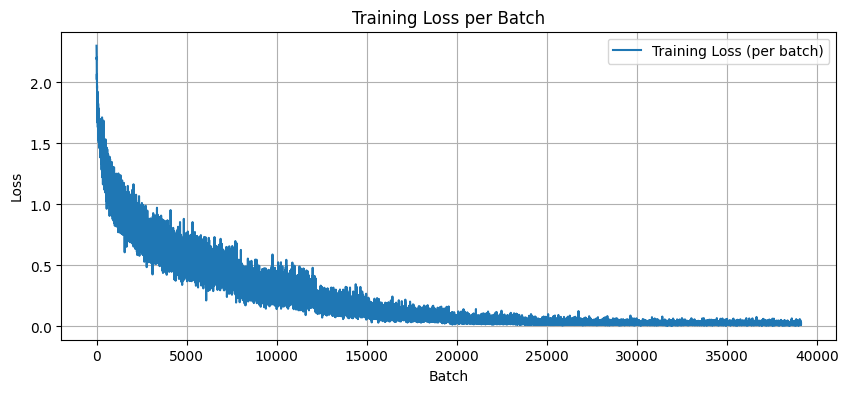

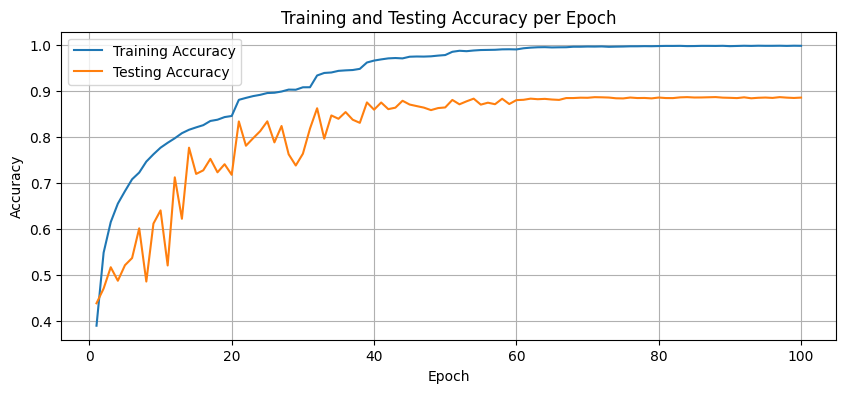


 Best Testing Accuracy: 0.8860


In [ ]:
K = 6
L = 4
out_channels_per_block = 64
output_hidden_units = 128
batch_size = 128
num_epochs = 100
learning_rate = 0.001

conv_params_template = [
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1}
]
conv_params_per_block = [conv_params_template for _ in range(K)]
model = CIFAR10CustomNet(
    in_channels=3,
    num_blocks=K,
    conv_params_per_block=conv_params_per_block,
    out_channels_per_block=out_channels_per_block,
    output_hidden_units=output_hidden_units
)
train_iter, test_iter = load_data_cifar10(batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')
history_imp3 = train_model(
    model, train_iter, test_iter, device,
    num_epochs=num_epochs,
    lr=learning_rate
)

imropve 5
using sgd instead of adam
cosine annealing and randAug and 128 output channels and 250 epochs

Epoch 1: Train Loss=1.8214, Train Acc=0.3058, Test Loss=1.7553, Test Acc=0.3561


Epoch 2: Train Loss=1.5249, Train Acc=0.4337, Test Loss=2.2925, Test Acc=0.3335


Epoch 3: Train Loss=1.3649, Train Acc=0.4977, Test Loss=1.7353, Test Acc=0.4652


Epoch 4: Train Loss=1.2557, Train Acc=0.5443, Test Loss=1.4568, Test Acc=0.4889


Epoch 5: Train Loss=1.1630, Train Acc=0.5789, Test Loss=1.2793, Test Acc=0.5603


Epoch 6: Train Loss=1.0947, Train Acc=0.6072, Test Loss=1.1636, Test Acc=0.5904


Epoch 7: Train Loss=1.0464, Train Acc=0.6270, Test Loss=1.2728, Test Acc=0.5835


Epoch 8: Train Loss=0.9973, Train Acc=0.6423, Test Loss=1.1290, Test Acc=0.6166


Epoch 9: Train Loss=0.9715, Train Acc=0.6547, Test Loss=1.0986, Test Acc=0.6303


Epoch 10: Train Loss=0.9398, Train Acc=0.6668, Test Loss=1.1186, Test Acc=0.6240


Epoch 11: Train Loss=0.9024, Train Acc=0.6827, Test Loss=1.0370, Test Acc=0.6451


Epoch 12: Train Loss=0.8717, Train Acc=0.6948, Test Loss=1.0940, Test Acc=0.6433


Epoch 13: Train Loss=0.8545, Train Acc=0.7005, Test Loss=1.0827, Test Acc=0.6360


Epoch 14: Train Loss=0.8464, Train Acc=0.7053, Test Loss=1.3506, Test Acc=0.5846


Epoch 15: Train Loss=0.8336, Train Acc=0.7076, Test Loss=0.9159, Test Acc=0.6874


Epoch 16: Train Loss=0.8122, Train Acc=0.7177, Test Loss=4.1405, Test Acc=0.3554


Epoch 17: Train Loss=0.8013, Train Acc=0.7210, Test Loss=1.0166, Test Acc=0.6724


Epoch 18: Train Loss=0.7883, Train Acc=0.7226, Test Loss=0.9267, Test Acc=0.6907


Epoch 19: Train Loss=0.7816, Train Acc=0.7296, Test Loss=1.4182, Test Acc=0.5693


Epoch 20: Train Loss=0.7721, Train Acc=0.7303, Test Loss=0.9515, Test Acc=0.6819


Epoch 21: Train Loss=0.7700, Train Acc=0.7314, Test Loss=1.4857, Test Acc=0.6030


Epoch 22: Train Loss=0.7553, Train Acc=0.7384, Test Loss=1.5196, Test Acc=0.6081


Epoch 23: Train Loss=0.7603, Train Acc=0.7341, Test Loss=1.1555, Test Acc=0.6488


Epoch 24: Train Loss=0.7364, Train Acc=0.7428, Test Loss=0.9428, Test Acc=0.6976


Epoch 25: Train Loss=0.7403, Train Acc=0.7431, Test Loss=1.2331, Test Acc=0.6363


Epoch 26: Train Loss=0.7392, Train Acc=0.7421, Test Loss=1.5253, Test Acc=0.5738


Epoch 27: Train Loss=0.7303, Train Acc=0.7450, Test Loss=1.0864, Test Acc=0.6769


Epoch 28: Train Loss=0.7301, Train Acc=0.7476, Test Loss=0.8060, Test Acc=0.7392


Epoch 29: Train Loss=0.7212, Train Acc=0.7515, Test Loss=1.1914, Test Acc=0.6413


Epoch 30: Train Loss=0.7192, Train Acc=0.7511, Test Loss=0.8174, Test Acc=0.7318


Epoch 31: Train Loss=0.7175, Train Acc=0.7529, Test Loss=0.9576, Test Acc=0.6867


Epoch 32: Train Loss=0.7130, Train Acc=0.7519, Test Loss=0.9003, Test Acc=0.7031


Epoch 33: Train Loss=0.7113, Train Acc=0.7520, Test Loss=0.9372, Test Acc=0.6805


Epoch 34: Train Loss=0.7090, Train Acc=0.7526, Test Loss=1.4394, Test Acc=0.5947


Epoch 35: Train Loss=0.7018, Train Acc=0.7576, Test Loss=0.8016, Test Acc=0.7423


Epoch 36: Train Loss=0.7014, Train Acc=0.7560, Test Loss=1.4297, Test Acc=0.6170


Epoch 37: Train Loss=0.7039, Train Acc=0.7558, Test Loss=0.9434, Test Acc=0.6995


Epoch 38: Train Loss=0.6984, Train Acc=0.7585, Test Loss=0.9683, Test Acc=0.6951


Epoch 39: Train Loss=0.6829, Train Acc=0.7631, Test Loss=1.1377, Test Acc=0.6661


Epoch 40: Train Loss=0.6924, Train Acc=0.7606, Test Loss=1.2917, Test Acc=0.6460


Epoch 41: Train Loss=0.6858, Train Acc=0.7596, Test Loss=0.6995, Test Acc=0.7623


Epoch 42: Train Loss=0.6847, Train Acc=0.7619, Test Loss=0.7923, Test Acc=0.7367


Epoch 43: Train Loss=0.6807, Train Acc=0.7661, Test Loss=0.8710, Test Acc=0.7148


Epoch 44: Train Loss=0.6798, Train Acc=0.7654, Test Loss=1.2685, Test Acc=0.6478


Epoch 45: Train Loss=0.6796, Train Acc=0.7656, Test Loss=1.5500, Test Acc=0.5810


Epoch 46: Train Loss=0.6836, Train Acc=0.7634, Test Loss=0.7541, Test Acc=0.7490


Epoch 47: Train Loss=0.6744, Train Acc=0.7683, Test Loss=1.3186, Test Acc=0.6316


Epoch 48: Train Loss=0.6682, Train Acc=0.7696, Test Loss=0.9579, Test Acc=0.7128


Epoch 49: Train Loss=0.6749, Train Acc=0.7675, Test Loss=1.9318, Test Acc=0.5394


Epoch 50: Train Loss=0.6739, Train Acc=0.7665, Test Loss=1.3884, Test Acc=0.5975


Epoch 51: Train Loss=0.6621, Train Acc=0.7711, Test Loss=0.7084, Test Acc=0.7780


Epoch 52: Train Loss=0.6561, Train Acc=0.7723, Test Loss=0.7581, Test Acc=0.7574


Epoch 53: Train Loss=0.6572, Train Acc=0.7722, Test Loss=0.8379, Test Acc=0.7311


Epoch 54: Train Loss=0.6601, Train Acc=0.7708, Test Loss=0.6202, Test Acc=0.7894


Epoch 55: Train Loss=0.6585, Train Acc=0.7714, Test Loss=0.7448, Test Acc=0.7597


Epoch 56: Train Loss=0.6569, Train Acc=0.7713, Test Loss=1.2373, Test Acc=0.6797


Epoch 57: Train Loss=0.6480, Train Acc=0.7751, Test Loss=0.7716, Test Acc=0.7420


Epoch 58: Train Loss=0.6488, Train Acc=0.7748, Test Loss=1.0504, Test Acc=0.6689


Epoch 59: Train Loss=0.6538, Train Acc=0.7736, Test Loss=0.5962, Test Acc=0.8001


Epoch 60: Train Loss=0.6459, Train Acc=0.7775, Test Loss=1.0565, Test Acc=0.6879


Epoch 61: Train Loss=0.6493, Train Acc=0.7746, Test Loss=0.9758, Test Acc=0.7008


Epoch 62: Train Loss=0.6487, Train Acc=0.7740, Test Loss=0.8640, Test Acc=0.7283


Epoch 63: Train Loss=0.6403, Train Acc=0.7769, Test Loss=0.6784, Test Acc=0.7720


Epoch 64: Train Loss=0.6413, Train Acc=0.7794, Test Loss=0.6413, Test Acc=0.7887


Epoch 65: Train Loss=0.6448, Train Acc=0.7749, Test Loss=1.0678, Test Acc=0.6753


Epoch 66: Train Loss=0.6355, Train Acc=0.7819, Test Loss=0.8200, Test Acc=0.7371


Epoch 67: Train Loss=0.6381, Train Acc=0.7780, Test Loss=1.4815, Test Acc=0.6041


Epoch 68: Train Loss=0.6308, Train Acc=0.7815, Test Loss=0.6492, Test Acc=0.7870


Epoch 69: Train Loss=0.6282, Train Acc=0.7823, Test Loss=0.9498, Test Acc=0.7104


Epoch 70: Train Loss=0.6223, Train Acc=0.7823, Test Loss=1.2922, Test Acc=0.6400


Epoch 71: Train Loss=0.6345, Train Acc=0.7787, Test Loss=0.7720, Test Acc=0.7558


Epoch 72: Train Loss=0.6163, Train Acc=0.7867, Test Loss=0.8496, Test Acc=0.7302


Epoch 73: Train Loss=0.6260, Train Acc=0.7841, Test Loss=0.6765, Test Acc=0.7770


Epoch 74: Train Loss=0.6213, Train Acc=0.7851, Test Loss=1.0566, Test Acc=0.6756


Epoch 75: Train Loss=0.6269, Train Acc=0.7851, Test Loss=0.7586, Test Acc=0.7543


Epoch 76: Train Loss=0.6212, Train Acc=0.7853, Test Loss=0.9823, Test Acc=0.7113


Epoch 77: Train Loss=0.6218, Train Acc=0.7862, Test Loss=1.1956, Test Acc=0.6466


Epoch 78: Train Loss=0.6156, Train Acc=0.7881, Test Loss=0.7765, Test Acc=0.7490


Epoch 79: Train Loss=0.6080, Train Acc=0.7904, Test Loss=1.0426, Test Acc=0.6959


Epoch 80: Train Loss=0.6091, Train Acc=0.7901, Test Loss=1.1121, Test Acc=0.6832


Epoch 81: Train Loss=0.6159, Train Acc=0.7861, Test Loss=0.6279, Test Acc=0.7986


Epoch 82: Train Loss=0.6024, Train Acc=0.7918, Test Loss=1.1731, Test Acc=0.6925


Epoch 83: Train Loss=0.6003, Train Acc=0.7918, Test Loss=0.9307, Test Acc=0.7330


Epoch 84: Train Loss=0.5999, Train Acc=0.7939, Test Loss=0.7810, Test Acc=0.7464


Epoch 85: Train Loss=0.5933, Train Acc=0.7932, Test Loss=1.2352, Test Acc=0.6624


Epoch 86: Train Loss=0.6008, Train Acc=0.7914, Test Loss=1.0773, Test Acc=0.6576


Epoch 87: Train Loss=0.6002, Train Acc=0.7916, Test Loss=0.8440, Test Acc=0.7397


Epoch 88: Train Loss=0.5918, Train Acc=0.7956, Test Loss=1.2068, Test Acc=0.6712


Epoch 89: Train Loss=0.5931, Train Acc=0.7943, Test Loss=0.7513, Test Acc=0.7535


Epoch 90: Train Loss=0.5899, Train Acc=0.7977, Test Loss=1.2018, Test Acc=0.6796


Epoch 91: Train Loss=0.5835, Train Acc=0.7981, Test Loss=0.7137, Test Acc=0.7612


Epoch 92: Train Loss=0.5830, Train Acc=0.7959, Test Loss=1.0948, Test Acc=0.6793


Epoch 93: Train Loss=0.5833, Train Acc=0.7977, Test Loss=1.0450, Test Acc=0.7090


Epoch 94: Train Loss=0.5869, Train Acc=0.7955, Test Loss=0.7886, Test Acc=0.7452


Epoch 95: Train Loss=0.5785, Train Acc=0.7985, Test Loss=0.9605, Test Acc=0.7172


Epoch 96: Train Loss=0.5812, Train Acc=0.7993, Test Loss=1.0921, Test Acc=0.7057


Epoch 97: Train Loss=0.5811, Train Acc=0.8005, Test Loss=0.9643, Test Acc=0.6926


Epoch 98: Train Loss=0.5686, Train Acc=0.8050, Test Loss=0.6777, Test Acc=0.7875


Epoch 99: Train Loss=0.5788, Train Acc=0.7989, Test Loss=0.6967, Test Acc=0.7721


Epoch 100: Train Loss=0.5607, Train Acc=0.8051, Test Loss=0.9286, Test Acc=0.7453


Epoch 101: Train Loss=0.5660, Train Acc=0.8049, Test Loss=0.9844, Test Acc=0.7220


Epoch 102: Train Loss=0.5709, Train Acc=0.8017, Test Loss=1.1823, Test Acc=0.6658


Epoch 103: Train Loss=0.5633, Train Acc=0.8052, Test Loss=0.9023, Test Acc=0.7192


Epoch 104: Train Loss=0.5617, Train Acc=0.8061, Test Loss=1.1723, Test Acc=0.6749


Epoch 105: Train Loss=0.5585, Train Acc=0.8045, Test Loss=0.7279, Test Acc=0.7661


Epoch 106: Train Loss=0.5533, Train Acc=0.8085, Test Loss=0.8350, Test Acc=0.7551


Epoch 107: Train Loss=0.5472, Train Acc=0.8111, Test Loss=0.6845, Test Acc=0.7867


Epoch 108: Train Loss=0.5482, Train Acc=0.8105, Test Loss=0.7641, Test Acc=0.7562


Epoch 109: Train Loss=0.5487, Train Acc=0.8109, Test Loss=0.6426, Test Acc=0.7905


Epoch 110: Train Loss=0.5447, Train Acc=0.8102, Test Loss=0.8089, Test Acc=0.7602


Epoch 111: Train Loss=0.5460, Train Acc=0.8117, Test Loss=0.6348, Test Acc=0.7978


Epoch 112: Train Loss=0.5444, Train Acc=0.8118, Test Loss=0.9296, Test Acc=0.7072


Epoch 113: Train Loss=0.5439, Train Acc=0.8114, Test Loss=0.5064, Test Acc=0.8291


Epoch 114: Train Loss=0.5338, Train Acc=0.8163, Test Loss=0.6705, Test Acc=0.7755


Epoch 115: Train Loss=0.5345, Train Acc=0.8151, Test Loss=0.6071, Test Acc=0.8024


Epoch 116: Train Loss=0.5300, Train Acc=0.8148, Test Loss=0.7710, Test Acc=0.7686


Epoch 117: Train Loss=0.5332, Train Acc=0.8176, Test Loss=0.6097, Test Acc=0.7929


Epoch 118: Train Loss=0.5277, Train Acc=0.8186, Test Loss=0.9304, Test Acc=0.7379


Epoch 119: Train Loss=0.5203, Train Acc=0.8219, Test Loss=0.5631, Test Acc=0.8098


Epoch 120: Train Loss=0.5248, Train Acc=0.8184, Test Loss=0.6070, Test Acc=0.7970


Epoch 121: Train Loss=0.5155, Train Acc=0.8216, Test Loss=1.9188, Test Acc=0.5677


Epoch 122: Train Loss=0.5188, Train Acc=0.8186, Test Loss=0.9047, Test Acc=0.7408


Epoch 123: Train Loss=0.5155, Train Acc=0.8228, Test Loss=0.6115, Test Acc=0.8033


Epoch 124: Train Loss=0.5163, Train Acc=0.8211, Test Loss=1.0544, Test Acc=0.6835


Epoch 125: Train Loss=0.5092, Train Acc=0.8233, Test Loss=0.8168, Test Acc=0.7315


Epoch 126: Train Loss=0.5073, Train Acc=0.8259, Test Loss=0.6004, Test Acc=0.8001


Epoch 127: Train Loss=0.5019, Train Acc=0.8274, Test Loss=0.6920, Test Acc=0.7840


Epoch 128: Train Loss=0.4993, Train Acc=0.8276, Test Loss=0.6741, Test Acc=0.7886


Epoch 129: Train Loss=0.5009, Train Acc=0.8269, Test Loss=0.5845, Test Acc=0.8078


Epoch 130: Train Loss=0.4961, Train Acc=0.8288, Test Loss=0.4777, Test Acc=0.8445


Epoch 131: Train Loss=0.4896, Train Acc=0.8304, Test Loss=0.6897, Test Acc=0.7781


Epoch 132: Train Loss=0.4942, Train Acc=0.8284, Test Loss=0.8224, Test Acc=0.7555


Epoch 133: Train Loss=0.4791, Train Acc=0.8332, Test Loss=0.8455, Test Acc=0.7498


Epoch 134: Train Loss=0.4936, Train Acc=0.8300, Test Loss=0.6995, Test Acc=0.7741


Epoch 135: Train Loss=0.4802, Train Acc=0.8332, Test Loss=0.4692, Test Acc=0.8444


Epoch 136: Train Loss=0.4751, Train Acc=0.8345, Test Loss=0.7277, Test Acc=0.7673


Epoch 137: Train Loss=0.4763, Train Acc=0.8346, Test Loss=0.6751, Test Acc=0.7796


Epoch 138: Train Loss=0.4679, Train Acc=0.8368, Test Loss=0.4750, Test Acc=0.8406


Epoch 139: Train Loss=0.4654, Train Acc=0.8378, Test Loss=0.6579, Test Acc=0.7979


Epoch 140: Train Loss=0.4703, Train Acc=0.8383, Test Loss=0.8141, Test Acc=0.7473


Epoch 141: Train Loss=0.4635, Train Acc=0.8396, Test Loss=0.5503, Test Acc=0.8179


Epoch 142: Train Loss=0.4609, Train Acc=0.8398, Test Loss=0.5080, Test Acc=0.8352


Epoch 143: Train Loss=0.4539, Train Acc=0.8434, Test Loss=0.6850, Test Acc=0.7890


Epoch 144: Train Loss=0.4558, Train Acc=0.8420, Test Loss=0.6592, Test Acc=0.7938


Epoch 145: Train Loss=0.4540, Train Acc=0.8430, Test Loss=0.8852, Test Acc=0.7309


Epoch 146: Train Loss=0.4539, Train Acc=0.8424, Test Loss=0.4784, Test Acc=0.8411


Epoch 147: Train Loss=0.4475, Train Acc=0.8451, Test Loss=0.6731, Test Acc=0.7855


Epoch 148: Train Loss=0.4325, Train Acc=0.8505, Test Loss=1.1974, Test Acc=0.7070


Epoch 149: Train Loss=0.4463, Train Acc=0.8460, Test Loss=0.4865, Test Acc=0.8433


Epoch 150: Train Loss=0.4397, Train Acc=0.8478, Test Loss=0.8923, Test Acc=0.7419


Epoch 151: Train Loss=0.4362, Train Acc=0.8497, Test Loss=0.8939, Test Acc=0.7571


Epoch 152: Train Loss=0.4303, Train Acc=0.8519, Test Loss=0.5364, Test Acc=0.8262


Epoch 153: Train Loss=0.4303, Train Acc=0.8495, Test Loss=0.6078, Test Acc=0.8189


Epoch 154: Train Loss=0.4275, Train Acc=0.8535, Test Loss=0.5730, Test Acc=0.8178


Epoch 155: Train Loss=0.4218, Train Acc=0.8532, Test Loss=0.5912, Test Acc=0.8237


Epoch 156: Train Loss=0.4243, Train Acc=0.8524, Test Loss=0.5357, Test Acc=0.8252


Epoch 157: Train Loss=0.4124, Train Acc=0.8557, Test Loss=0.5442, Test Acc=0.8211


Epoch 158: Train Loss=0.4075, Train Acc=0.8587, Test Loss=0.5822, Test Acc=0.8192


Epoch 159: Train Loss=0.4085, Train Acc=0.8576, Test Loss=0.6172, Test Acc=0.8051


Epoch 160: Train Loss=0.4063, Train Acc=0.8588, Test Loss=0.5162, Test Acc=0.8355


Epoch 161: Train Loss=0.3995, Train Acc=0.8609, Test Loss=0.7034, Test Acc=0.8012


Epoch 162: Train Loss=0.3982, Train Acc=0.8616, Test Loss=0.4842, Test Acc=0.8437


Epoch 163: Train Loss=0.3921, Train Acc=0.8645, Test Loss=0.6772, Test Acc=0.7958


Epoch 164: Train Loss=0.3918, Train Acc=0.8642, Test Loss=0.4562, Test Acc=0.8551


Epoch 165: Train Loss=0.3876, Train Acc=0.8662, Test Loss=0.4395, Test Acc=0.8546


Epoch 166: Train Loss=0.3836, Train Acc=0.8677, Test Loss=0.4377, Test Acc=0.8595


Epoch 167: Train Loss=0.3795, Train Acc=0.8702, Test Loss=0.6028, Test Acc=0.8187


Epoch 168: Train Loss=0.3702, Train Acc=0.8727, Test Loss=0.5517, Test Acc=0.8220


Epoch 169: Train Loss=0.3705, Train Acc=0.8715, Test Loss=0.6139, Test Acc=0.8165


Epoch 170: Train Loss=0.3702, Train Acc=0.8706, Test Loss=0.6189, Test Acc=0.8222


Epoch 171: Train Loss=0.3641, Train Acc=0.8751, Test Loss=0.4695, Test Acc=0.8489


Epoch 172: Train Loss=0.3621, Train Acc=0.8748, Test Loss=0.4386, Test Acc=0.8583


Epoch 173: Train Loss=0.3581, Train Acc=0.8760, Test Loss=0.4659, Test Acc=0.8520


Epoch 174: Train Loss=0.3520, Train Acc=0.8773, Test Loss=0.4394, Test Acc=0.8619


Epoch 175: Train Loss=0.3492, Train Acc=0.8779, Test Loss=0.5856, Test Acc=0.8263


Epoch 176: Train Loss=0.3440, Train Acc=0.8801, Test Loss=0.5197, Test Acc=0.8312


Epoch 177: Train Loss=0.3425, Train Acc=0.8799, Test Loss=0.6835, Test Acc=0.8040


Epoch 178: Train Loss=0.3343, Train Acc=0.8842, Test Loss=0.4510, Test Acc=0.8591


Epoch 179: Train Loss=0.3345, Train Acc=0.8838, Test Loss=0.4372, Test Acc=0.8643


Epoch 180: Train Loss=0.3239, Train Acc=0.8886, Test Loss=0.5195, Test Acc=0.8385


Epoch 181: Train Loss=0.3278, Train Acc=0.8861, Test Loss=0.6427, Test Acc=0.8124


Epoch 182: Train Loss=0.3170, Train Acc=0.8899, Test Loss=0.3686, Test Acc=0.8827


Epoch 183: Train Loss=0.3182, Train Acc=0.8894, Test Loss=0.4195, Test Acc=0.8674


Epoch 184: Train Loss=0.3101, Train Acc=0.8919, Test Loss=0.5347, Test Acc=0.8361


Epoch 185: Train Loss=0.3094, Train Acc=0.8919, Test Loss=0.4887, Test Acc=0.8513


Epoch 186: Train Loss=0.3040, Train Acc=0.8939, Test Loss=0.3771, Test Acc=0.8784


Epoch 187: Train Loss=0.2997, Train Acc=0.8957, Test Loss=0.4519, Test Acc=0.8642


Epoch 188: Train Loss=0.2943, Train Acc=0.8977, Test Loss=0.4502, Test Acc=0.8668


Epoch 189: Train Loss=0.2948, Train Acc=0.8975, Test Loss=0.3925, Test Acc=0.8796


Epoch 190: Train Loss=0.2846, Train Acc=0.9025, Test Loss=0.5544, Test Acc=0.8413


Epoch 191: Train Loss=0.2784, Train Acc=0.9052, Test Loss=0.4270, Test Acc=0.8704


Epoch 192: Train Loss=0.2731, Train Acc=0.9037, Test Loss=0.3469, Test Acc=0.8890


Epoch 193: Train Loss=0.2705, Train Acc=0.9060, Test Loss=0.4139, Test Acc=0.8748


Epoch 194: Train Loss=0.2669, Train Acc=0.9065, Test Loss=0.4563, Test Acc=0.8618


Epoch 195: Train Loss=0.2609, Train Acc=0.9091, Test Loss=0.4266, Test Acc=0.8695


Epoch 196: Train Loss=0.2557, Train Acc=0.9113, Test Loss=0.4758, Test Acc=0.8620


Epoch 197: Train Loss=0.2534, Train Acc=0.9115, Test Loss=0.4552, Test Acc=0.8637


Epoch 198: Train Loss=0.2463, Train Acc=0.9155, Test Loss=0.3547, Test Acc=0.8903


Epoch 199: Train Loss=0.2409, Train Acc=0.9165, Test Loss=0.4215, Test Acc=0.8702


Epoch 200: Train Loss=0.2387, Train Acc=0.9176, Test Loss=0.3516, Test Acc=0.8945


Epoch 201: Train Loss=0.2312, Train Acc=0.9204, Test Loss=0.3534, Test Acc=0.8925


Epoch 202: Train Loss=0.2305, Train Acc=0.9197, Test Loss=0.3940, Test Acc=0.8849


Epoch 203: Train Loss=0.2258, Train Acc=0.9215, Test Loss=0.3532, Test Acc=0.8929


Epoch 204: Train Loss=0.2221, Train Acc=0.9230, Test Loss=0.3246, Test Acc=0.9016


Epoch 205: Train Loss=0.2124, Train Acc=0.9254, Test Loss=0.3262, Test Acc=0.8996


Epoch 206: Train Loss=0.2072, Train Acc=0.9292, Test Loss=0.3769, Test Acc=0.8843


Epoch 207: Train Loss=0.2043, Train Acc=0.9285, Test Loss=0.4248, Test Acc=0.8738


Epoch 208: Train Loss=0.1958, Train Acc=0.9315, Test Loss=0.3814, Test Acc=0.8860


Epoch 209: Train Loss=0.1925, Train Acc=0.9341, Test Loss=0.4847, Test Acc=0.8656


Epoch 210: Train Loss=0.1853, Train Acc=0.9361, Test Loss=0.3719, Test Acc=0.8879


Epoch 211: Train Loss=0.1825, Train Acc=0.9375, Test Loss=0.3583, Test Acc=0.8929


Epoch 212: Train Loss=0.1753, Train Acc=0.9404, Test Loss=0.3629, Test Acc=0.8944


Epoch 213: Train Loss=0.1758, Train Acc=0.9398, Test Loss=0.3856, Test Acc=0.8847


Epoch 214: Train Loss=0.1671, Train Acc=0.9443, Test Loss=0.3330, Test Acc=0.9006


Epoch 215: Train Loss=0.1628, Train Acc=0.9451, Test Loss=0.3014, Test Acc=0.9101


Epoch 216: Train Loss=0.1583, Train Acc=0.9459, Test Loss=0.3072, Test Acc=0.9094


Epoch 217: Train Loss=0.1497, Train Acc=0.9506, Test Loss=0.3228, Test Acc=0.9072


Epoch 218: Train Loss=0.1467, Train Acc=0.9507, Test Loss=0.2881, Test Acc=0.9139


Epoch 219: Train Loss=0.1409, Train Acc=0.9521, Test Loss=0.3054, Test Acc=0.9103


Epoch 220: Train Loss=0.1361, Train Acc=0.9546, Test Loss=0.2969, Test Acc=0.9107


Epoch 221: Train Loss=0.1291, Train Acc=0.9572, Test Loss=0.3104, Test Acc=0.9111


Epoch 222: Train Loss=0.1312, Train Acc=0.9564, Test Loss=0.3018, Test Acc=0.9089


Epoch 223: Train Loss=0.1258, Train Acc=0.9588, Test Loss=0.3154, Test Acc=0.9045


Epoch 224: Train Loss=0.1200, Train Acc=0.9618, Test Loss=0.2758, Test Acc=0.9198


Epoch 225: Train Loss=0.1175, Train Acc=0.9611, Test Loss=0.2830, Test Acc=0.9171


Epoch 226: Train Loss=0.1132, Train Acc=0.9629, Test Loss=0.2813, Test Acc=0.9189


Epoch 227: Train Loss=0.1103, Train Acc=0.9648, Test Loss=0.2705, Test Acc=0.9198


Epoch 228: Train Loss=0.1086, Train Acc=0.9641, Test Loss=0.2663, Test Acc=0.9224


Epoch 229: Train Loss=0.1033, Train Acc=0.9671, Test Loss=0.2705, Test Acc=0.9197


Epoch 230: Train Loss=0.1012, Train Acc=0.9674, Test Loss=0.2659, Test Acc=0.9194


Epoch 231: Train Loss=0.0989, Train Acc=0.9685, Test Loss=0.2601, Test Acc=0.9242


Epoch 232: Train Loss=0.0966, Train Acc=0.9691, Test Loss=0.2565, Test Acc=0.9252


Epoch 233: Train Loss=0.0929, Train Acc=0.9711, Test Loss=0.2480, Test Acc=0.9289


Epoch 234: Train Loss=0.0900, Train Acc=0.9719, Test Loss=0.2517, Test Acc=0.9260


Epoch 235: Train Loss=0.0867, Train Acc=0.9731, Test Loss=0.2476, Test Acc=0.9263


Epoch 236: Train Loss=0.0868, Train Acc=0.9730, Test Loss=0.2467, Test Acc=0.9284


Epoch 237: Train Loss=0.0866, Train Acc=0.9726, Test Loss=0.2499, Test Acc=0.9259


Epoch 238: Train Loss=0.0823, Train Acc=0.9744, Test Loss=0.2452, Test Acc=0.9287


Epoch 239: Train Loss=0.0834, Train Acc=0.9737, Test Loss=0.2494, Test Acc=0.9271


Epoch 240: Train Loss=0.0813, Train Acc=0.9745, Test Loss=0.2481, Test Acc=0.9267


Epoch 241: Train Loss=0.0829, Train Acc=0.9743, Test Loss=0.2483, Test Acc=0.9279


Epoch 242: Train Loss=0.0787, Train Acc=0.9759, Test Loss=0.2451, Test Acc=0.9291


Epoch 243: Train Loss=0.0787, Train Acc=0.9760, Test Loss=0.2465, Test Acc=0.9281


Epoch 244: Train Loss=0.0780, Train Acc=0.9763, Test Loss=0.2435, Test Acc=0.9290


Epoch 245: Train Loss=0.0771, Train Acc=0.9771, Test Loss=0.2452, Test Acc=0.9287


Epoch 246: Train Loss=0.0770, Train Acc=0.9770, Test Loss=0.2457, Test Acc=0.9288


Epoch 247: Train Loss=0.0772, Train Acc=0.9761, Test Loss=0.2442, Test Acc=0.9281


Epoch 248: Train Loss=0.0766, Train Acc=0.9766, Test Loss=0.2448, Test Acc=0.9287


Epoch 249: Train Loss=0.0757, Train Acc=0.9763, Test Loss=0.2460, Test Acc=0.9285


Epoch 250: Train Loss=0.0747, Train Acc=0.9773, Test Loss=0.2458, Test Acc=0.9278


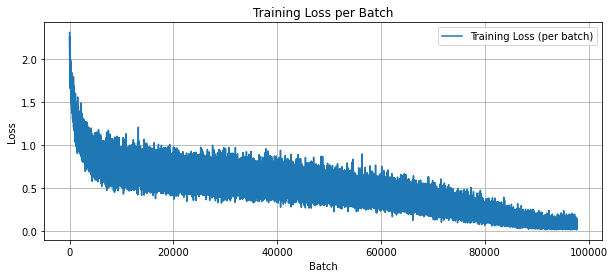

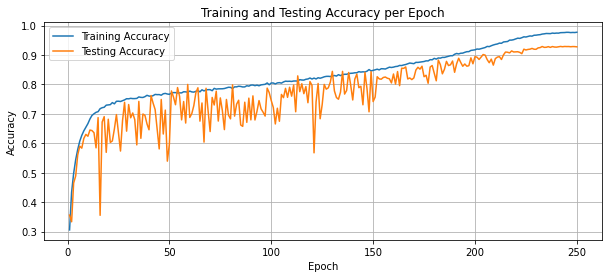


🎯 Best Testing Accuracy: 0.9291


In [ ]:
from torchvision import transforms


def load_data_cifar10(batch_size, resize=None):
    normalize = transforms.Normalize(
        mean=[0.4915, 0.4823, 0.4468],
        std=[0.2470, 0.2435, 0.2616]
    )

    train_transforms = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        normalize
    ])

    test_transforms = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    cifar_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=train_transforms, download=True)
    cifar_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=test_transforms, download=True)

    return (
        torch.utils.data.DataLoader(cifar_train, batch_size, shuffle=True, num_workers=2, pin_memory=True),
        torch.utils.data.DataLoader(cifar_test, batch_size, shuffle=False, num_workers=2, pin_memory=True)
    )

def train_model(model, train_loader, test_loader, device,
                num_epochs=250, lr=0.1):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    # SGD with momentum
    optimizer = torch.optim.SGD(
        model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4
    )

    # Cosine Annealing LR scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    history = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': [],
        'batch_losses': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc, batch_losses = train_epoch(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['batch_losses'].extend(batch_losses)

        scheduler.step()

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

    plot_batch_losses(history['batch_losses'])
    plot_epoch_accuracies(history['train_acc'], history['test_acc'])

    best_test_acc = max(history['test_acc'])
    print(f"\n🎯 Best Testing Accuracy: {best_test_acc:.4f}")

    return history

K = 6
L = 4
out_channels_per_block = 128
output_hidden_units = 128
batch_size = 128
num_epochs = 250
learning_rate = 0.1

conv_params_template = [
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1},
    {'kernel_size': 3, 'padding': 1}
]
conv_params_per_block = [conv_params_template for _ in range(K)]
model = CIFAR10CustomNet(
    in_channels=3,
    num_blocks=K,
    conv_params_per_block=conv_params_per_block,
    out_channels_per_block=out_channels_per_block,
    output_hidden_units=output_hidden_units
)
train_iter, test_iter = load_data_cifar10(batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')
history_imp3 = train_model(
    model, train_iter, test_iter, device,
    num_epochs=num_epochs,
    lr=learning_rate
)

more epochs